In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [9]:
def getSetRatings(setFName):
    uSetRatings = {}
    nSets = 0
    with open(setFName, 'r') as f:
        for line in f:
            cols   = line.strip().split(',')
            user   = int(cols[0])
            uItems = map(int, cols[1].split('-'))
            rating = float(cols[2])
            if user not in uSetRatings:
                uSetRatings[user] = []
            uSetRatings[user].append((uItems, rating))
            nSets+= 1
    print 'No. of sets: ', nSets
    return uSetRatings

def getUIRatings(ratFName):
    uiRatings = {}
    uinnz = 0
    with open(ratFName, 'r') as f:
        for line in f:
            cols = line.strip().split(',')
            user = int(cols[0])
            item = int(cols[1])
            rating = float(cols[2])
            if user not in uiRatings:
                uiRatings[user] = {}
            uiRatings[user][item] = rating
            uinnz += 1
    print 'No. of u-i ratings: ', uinnz
    return uiRatings

import datetime
def getUITstamp(ratFName):
    uiTstamp = {}
    with open(ratFName, 'r') as f:
        for line in f:
            cols = line.strip().split(',')
            user = int(cols[0])
            item = int(cols[1])
            rating = float(cols[2])
            tstampStr = cols[3]
            tstamp = datetime.datetime.strptime(tstampStr, "%Y-%m-%d %H:%M:%S")
            if user not in uiTstamp:
                uiTstamp[user] = {}
            uiTstamp[user][item] = tstamp
    return uiTstamp


In [10]:
uSetRatings = getSetRatings('db_filt_set_ratings.csv')
uiRatings = getUIRatings('db_ui_ratings.csv')
uiTstamp = getUITstamp('db_ui_ratings.csv')

No. of sets:  29516
No. of u-i ratings:  510032


In [11]:
def avgSetRat(user, items):
    rat = 0.0
    for item in items:
        rat += uiRatings[user][item]
    rat = rat/len(items)
    return rat

UNDER_RATED_SET   = 1
OVER_RATED_SET    = 2
NEITHER_RATED_SET = 0
def isSetUnderOverRat(user, items, rating):
    avgRat = avgSetRat(user, items)
    if avgRat >= rating + 0.5:
        #under rat
        return UNDER_RATED_SET
    elif avgRat <= rating - 0.5:
        #over rat
        return OVER_RATED_SET
    else:
        return NEITHER_RATED_SET
    
def hexbin(x, y, xlabel, ylabel, label='count'):
    plt.hexbin(x, y, gridsize=10, cmap=plt.cm.YlOrRd_r, bins=None)
    plt.axis([0.5, 5, 0.5, 5])
    cb = plt.colorbar()
    cb.set_label(label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def rmse(l1, l2):
    a1 = np.asarray(l1)
    a2 = np.asarray(l2)
    n = len(l1)
    return np.sqrt(np.sum(np.square(a1 - a2))/n)

def getUserSetsAvgRatings():
    origSetRatings = []
    origAvgSetRatings = []
    underRatedCount = 0
    overRatedCount = 0

    nUnderRatedSets = 0
    seUnderRatedSets = 0

    nOverRatedSets = 0
    seOverRatedSets = 0

    nNeitherSets = 0
    seNeitherSets = 0
    
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        userUnderRatedCount[user]  = 0
        userOverRatedCount[user] = 0
        for itemSetNRat in itemsSetsNRat:
            
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            avgRat = avgSetRat(user, items)
            
            for item in items:
                if item not in itemUnderRatedCount:
                    itemUnderRatedCount[item] = 0
                if item not in itemOverRatedCount:
                    itemOverRatedCount[item] = 0
                if item not in itemSetCount:
                    itemSetCount[item] = 0
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                itemSetCount[item] += 1
            
            setRatingType = isSetUnderOverRat(user, items, setRat)
            
            if setRatingType == UNDER_RATED_SET:
                nUnderRatedSets += 1
                seUnderRatedSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uUnderRatedSetRatings:
                    uUnderRatedSetRatings[user] = []
                uUnderRatedSetRatings[user].append(itemSetNRat)
                underRatedCount += 1
                userUnderRatedCount[user] += 1
                for item in items:
                    itemUnderRatedCount[item] += 1
            elif setRatingType == OVER_RATED_SET:
                nOverRatedSets += 1
                seOverRatedSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uOverRatedSetRatings:
                    uOverRatedSetRatings[user] = []
                uOverRatedSetRatings[user].append(itemSetNRat)
                overRatedCount += 1
                userOverRatedCount[user] += 1
                for item in items:
                    itemOverRatedCount[item] += 1
            else:
                nNeitherSets += 1
                seNeitherSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uNeitherRatedSetRatings:
                    uNeitherRatedSetRatings[user] = []
                uNeitherRatedSetRatings[user].append(itemSetNRat)
                
            origSetRatings.append(setRat)
            origAvgSetRatings.append(avgRat)
    hexbin(origSetRatings, origAvgSetRatings, 'set ratings', 'average ratings')
    print 'rmse: ', rmse(origSetRatings, origAvgSetRatings)
    
    print 'nUnderRatedSets: ', nUnderRatedSets, ' underRatedRMSE: ', np.sqrt(seUnderRatedSets/nUnderRatedSets)
    print 'nOverRatedSets: ', nOverRatedSets, ' overRatedRMSE: ', np.sqrt(seOverRatedSets/nOverRatedSets)
    print 'nNeitherSets: ', nNeitherSets, ' neitherSetsRMSE: ', np.sqrt(seNeitherSets/nNeitherSets)
    
    print 'underRatedCount: ', underRatedCount, len(uUnderRatedSetRatings)
    print 'overRatedCount: ', overRatedCount, len(uOverRatedSetRatings)
    return (origSetRatings, origAvgSetRatings)

rmse:  0.597961482605
nUnderRatedSets:  6571  underRatedRMSE:  0.962637906724
nOverRatedSets:  5220  overRatedRMSE:  0.810604996142
nNeitherSets:  17725  neitherSetsRMSE:  0.241593207388
underRatedCount:  6571 731
overRatedCount:  5220 706


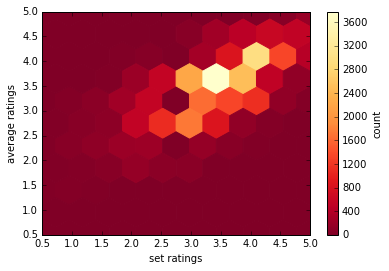

In [12]:
userUnderRatedCount = {}
userOverRatedCount  = {}
itemUnderRatedCount = {}
itemOverRatedCount  = {}
itemSetCount        = {}

uUnderRatedSetRatings   = {}
uOverRatedSetRatings    = {}
uNeitherRatedSetRatings = {}
(origSetRatingsA, origAvgSetRatings) = getUserSetsAvgRatings()

In [13]:
def getSetDevFrmAvg(user, items):
    avgRat = avgSetRat(user, items)
    sqDev = 0
    for item in items:
        diffFrmAvg = uiRatings[user][item] - avgRat
        sqDev += diffFrmAvg*diffFrmAvg
    sqDev = sqDev/len(items)
    return np.sqrt(sqDev)

def getSetDev(userSetRatings):
    nSets = 0
    avgSetDev = 0
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            setDev = getSetDevFrmAvg(user, items)
            avgSetDev += setDev
            nSets += 1
    avgSetDev = avgSetDev/nSets
    return avgSetDev

def getSetDevs(userSetRatings):
    nSets = 0
    setDevs = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            setDev = getSetDevFrmAvg(user, items)
            setDevs.append(setDev)
            nSets += 1
    return setDevs

In [14]:
print 'underRated setDev:', getSetDev(uUnderRatedSetRatings)
print 'overRated setDev: ', getSetDev(uOverRatedSetRatings)
print 'neither setDev: ', getSetDev(uNeitherRatedSetRatings)


underRated setDev: 0.731148429721
overRated setDev:  0.827304409635
neither setDev:  0.682317600459


In [179]:
#go over sets and see if high diversity sets tend to be overrated or underrated
nSets           = 0.0
RMSE            = 0.0
nDiverseSets    = 0.0
diverseRMSE     = 0.0
nNotDiverseSets = 0.0
notDiverseRMSE  = 0.0

nUnderRatedSets           = 0.0
underRatedRMSE            = 0.0
nDiverseUnderRatedSets    = 0.0
diverseUnderRatedRMSE     = 0.0
nNotDiverseUnderRatedSets = 0.0
notDiverseUnderRatedRMSE  = 0.0

nOverRatedSets           = 0.0
overRatedRMSE            = 0.0
nDiverseOverRatedSets    = 0.0
diverseOverRatedRMSE     = 0.0
nNotDiverseOverRatedSets = 0.0
notDiverseOverRatedRMSE  = 0.0

nNeitherRatedSets = 0.0
neitherRatedRMSE  = 0.0
nDiverseNeitherRatedSets = 0.0
diverseNeitherRatedRMSE  = 0.0
nNotDiverseNeitherRatedSets = 0.0
notDiverseNeitherRatedRMSE = 0.0

diverseSetRating = []
nonDiverseSetRating = []

for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        setDev = getSetDevFrmAvg(user, items)
        avgRat = avgSetRat(user, items)
        diff = avgRat - rating
        seDiff = diff*diff
        nSets += 1
        RMSE += seDiff
        setRatingType = isSetUnderOverRat(user, items, rating)
        
        if setRatingType == UNDER_RATED_SET:
            nUnderRatedSets += 1
            underRatedRMSE += seDiff
        elif setRatingType == OVER_RATED_SET:
            nOverRatedSets += 1
            overRatedRMSE += seDiff
        else:
            nNeitherRatedSets += 1
            neitherRatedRMSE += seDiff
            
        if setDev >= 1:
            #set has polarized ratings
            diverseSetRating.append(rating)
            nDiverseSets += 1
            diverseRMSE += seDiff
            if setRatingType == UNDER_RATED_SET:
                nDiverseUnderRatedSets += 1
                diverseUnderRatedRMSE += seDiff
            elif setRatingType == OVER_RATED_SET:
                nDiverseOverRatedSets += 1
                diverseOverRatedRMSE += seDiff
            else:
                nDiverseNeitherRatedSets += 1
                diverseNeitherRatedRMSE += seDiff
        else:
            nonDiverseSetRating.append(rating)
            nNotDiverseSets += 1
            notDiverseRMSE += seDiff
            if setRatingType == UNDER_RATED_SET:
                nNotDiverseUnderRatedSets += 1
                notDiverseUnderRatedRMSE += seDiff
            elif setRatingType == OVER_RATED_SET:
                nNotDiverseOverRatedSets += 1
                notDiverseOverRatedRMSE += seDiff
            else:
                nNotDiverseNeitherRatedSets += 1
                notDiverseNeitherRatedRMSE += seDiff
            
print 'nSets: ', nSets , 'RMSE: ', np.sqrt(RMSE/nSets)
print 'underRated(%): ', float(nUnderRatedSets)/nSets, 'RMSE: ', np.sqrt(underRatedRMSE/nUnderRatedSets)
print 'overRated(%): ', float(nOverRatedSets)/nSets, 'RMSE: ', np.sqrt(overRatedRMSE/nOverRatedSets)
print 'neitherRated(%): ', float(nNeitherRatedSets)/nSets, 'RMSE: ', np.sqrt(neitherRatedRMSE/nNeitherRatedSets)
print ' '

print 'diverse sets: ', nDiverseSets, 'RMSE: ', np.sqrt(diverseRMSE/ nDiverseSets)
print 'diverse underRated(%): ', float(nDiverseUnderRatedSets)/nDiverseSets, 'RMSE: ', np.sqrt(diverseUnderRatedRMSE/nDiverseUnderRatedSets)
print 'diverse overRated(%): ', float(nDiverseOverRatedSets)/nDiverseSets, 'RMSE: ', np.sqrt(diverseOverRatedRMSE/nDiverseOverRatedSets)
print 'diverse neitherRated(%): ', float(nDiverseNeitherRatedSets)/nDiverseSets, 'RMSE: ', np.sqrt(diverseNeitherRatedRMSE/nDiverseNeitherRatedSets)
print ' '

print 'not diverse sets: ', nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseRMSE/nNotDiverseSets)
print 'not diverse underRated(%): ', float(nNotDiverseUnderRatedSets)/nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseUnderRatedRMSE/nNotDiverseUnderRatedSets) 
print 'not diverse overRated(%): ', float(nNotDiverseOverRatedSets)/nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseOverRatedRMSE/nNotDiverseOverRatedSets)
print 'not diverse neitherRated(%): ', float(nNotDiverseNeitherRatedSets)/nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseNeitherRatedRMSE/nNotDiverseNeitherRatedSets)


print stats.ttest_ind(diverseSetRating, nonDiverseSetRating)


nSets:  29516.0 RMSE:  0.597961482605
underRated(%):  0.22262501694 RMSE:  0.962637906724
overRated(%):  0.176853232145 RMSE:  0.810604996142
neitherRated(%):  0.600521750915 RMSE:  0.241593207388
 
diverse sets:  6128.0 RMSE:  0.725276799595
diverse underRated(%):  0.230580939948 RMSE:  1.09367026552
diverse overRated(%):  0.270561357702 RMSE:  0.901158616243
diverse neitherRated(%):  0.49885770235 RMSE:  0.247288203672
 
not diverse sets:  23388.0 RMSE:  0.55983632378
not diverse underRated(%):  0.220540448093 RMSE:  0.923503998647
not diverse overRated(%):  0.152300324953 RMSE:  0.764807044104
not diverse neitherRated(%):  0.627159226954 RMSE:  0.240389307919
Ttest_indResult(statistic=-39.460155123744791, pvalue=0.0)


In [131]:
uSetPc = {}
for user, setRatings in uSetRatings.iteritems():
    nSets = len(setRatings)
    nUnderRatedSets = 0
    nOverRatedSets = 0
    nNeitherRatedSets = 0
    if user in uUnderRatedSetRatings:
        nUnderRatedSets = float(len(uUnderRatedSetRatings[user]))
    if user in uOverRatedSetRatings:
        nOverRatedSets = float(len(uOverRatedSetRatings[user]))
    if user in uNeitherRatedSetRatings:
        nNeitherRatedSets = float(len(uNeitherRatedSetRatings[user]))
    if nUnderRatedSets + nOverRatedSets + nNeitherRatedSets != nSets:
        print 'No. of sets mismatch for', user
    uSetPc[user] = (nUnderRatedSets/nSets, nOverRatedSets/nSets, nNeitherRatedSets/nSets)

In [142]:
underRatedPc = []
overRatedPc = []
neitherRatedPc = []
pcTuples = []
for user, pcs in uSetPc.iteritems():
    setRatings = uSetRatings[user]
    nSets = len(setRatings)
    if nSets < 50:
        continue
    underRatedPc.append(pcs[0])
    overRatedPc.append(pcs[1])
    neitherRatedPc.append(pcs[2])
    pcTuples.append((pcs[0], pcs[1], pcs[2]))
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'seaborn-muted', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'classic', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


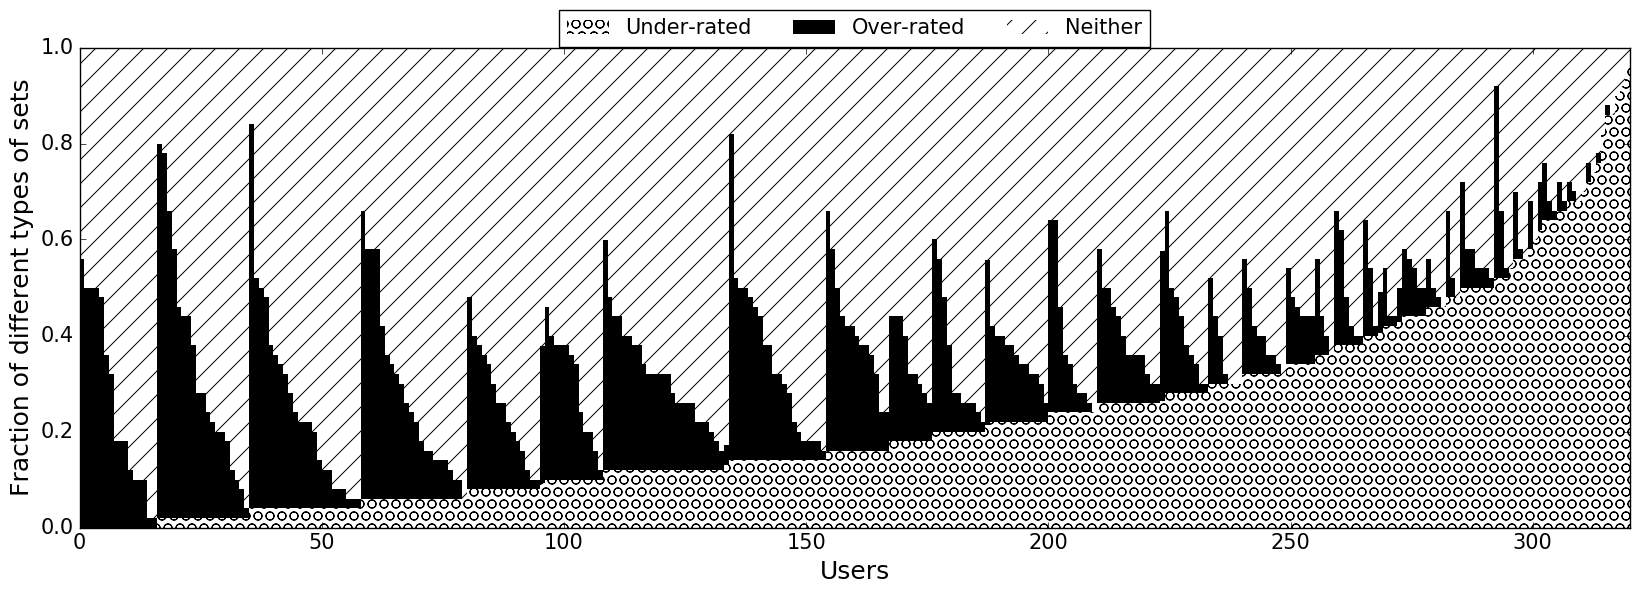

In [281]:
pcTuples.sort(key = lambda tup: tup[1])
pcTuples.sort(key = lambda tup: tup[2])
pcTuples.sort(key = lambda tup: tup[0])

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])
f = plt.figure(figsize = (20,6))
#f.patch.set_facecolor('blue')
plt.style.use('classic')
f.patch.set_alpha(0)
plt.bar(x, underRatedPcs, color = 'w', label='Under-rated', hatch='O', width=1, linewidth=0)
plt.bar(x, overRatedPcs, color = 'black', bottom = underRatedPcs, label='Over-rated', hatch='*', width=1, linewidth=0)
plt.bar(x, neitherRatedPcs, color='w', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='Neither',
       hatch='/', width=1, linewidth=0)
plt.axis("tight")
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=15)
plt.xlabel('Users', fontsize='18')
plt.ylabel('Fraction of different types of sets', fontsize='18')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)

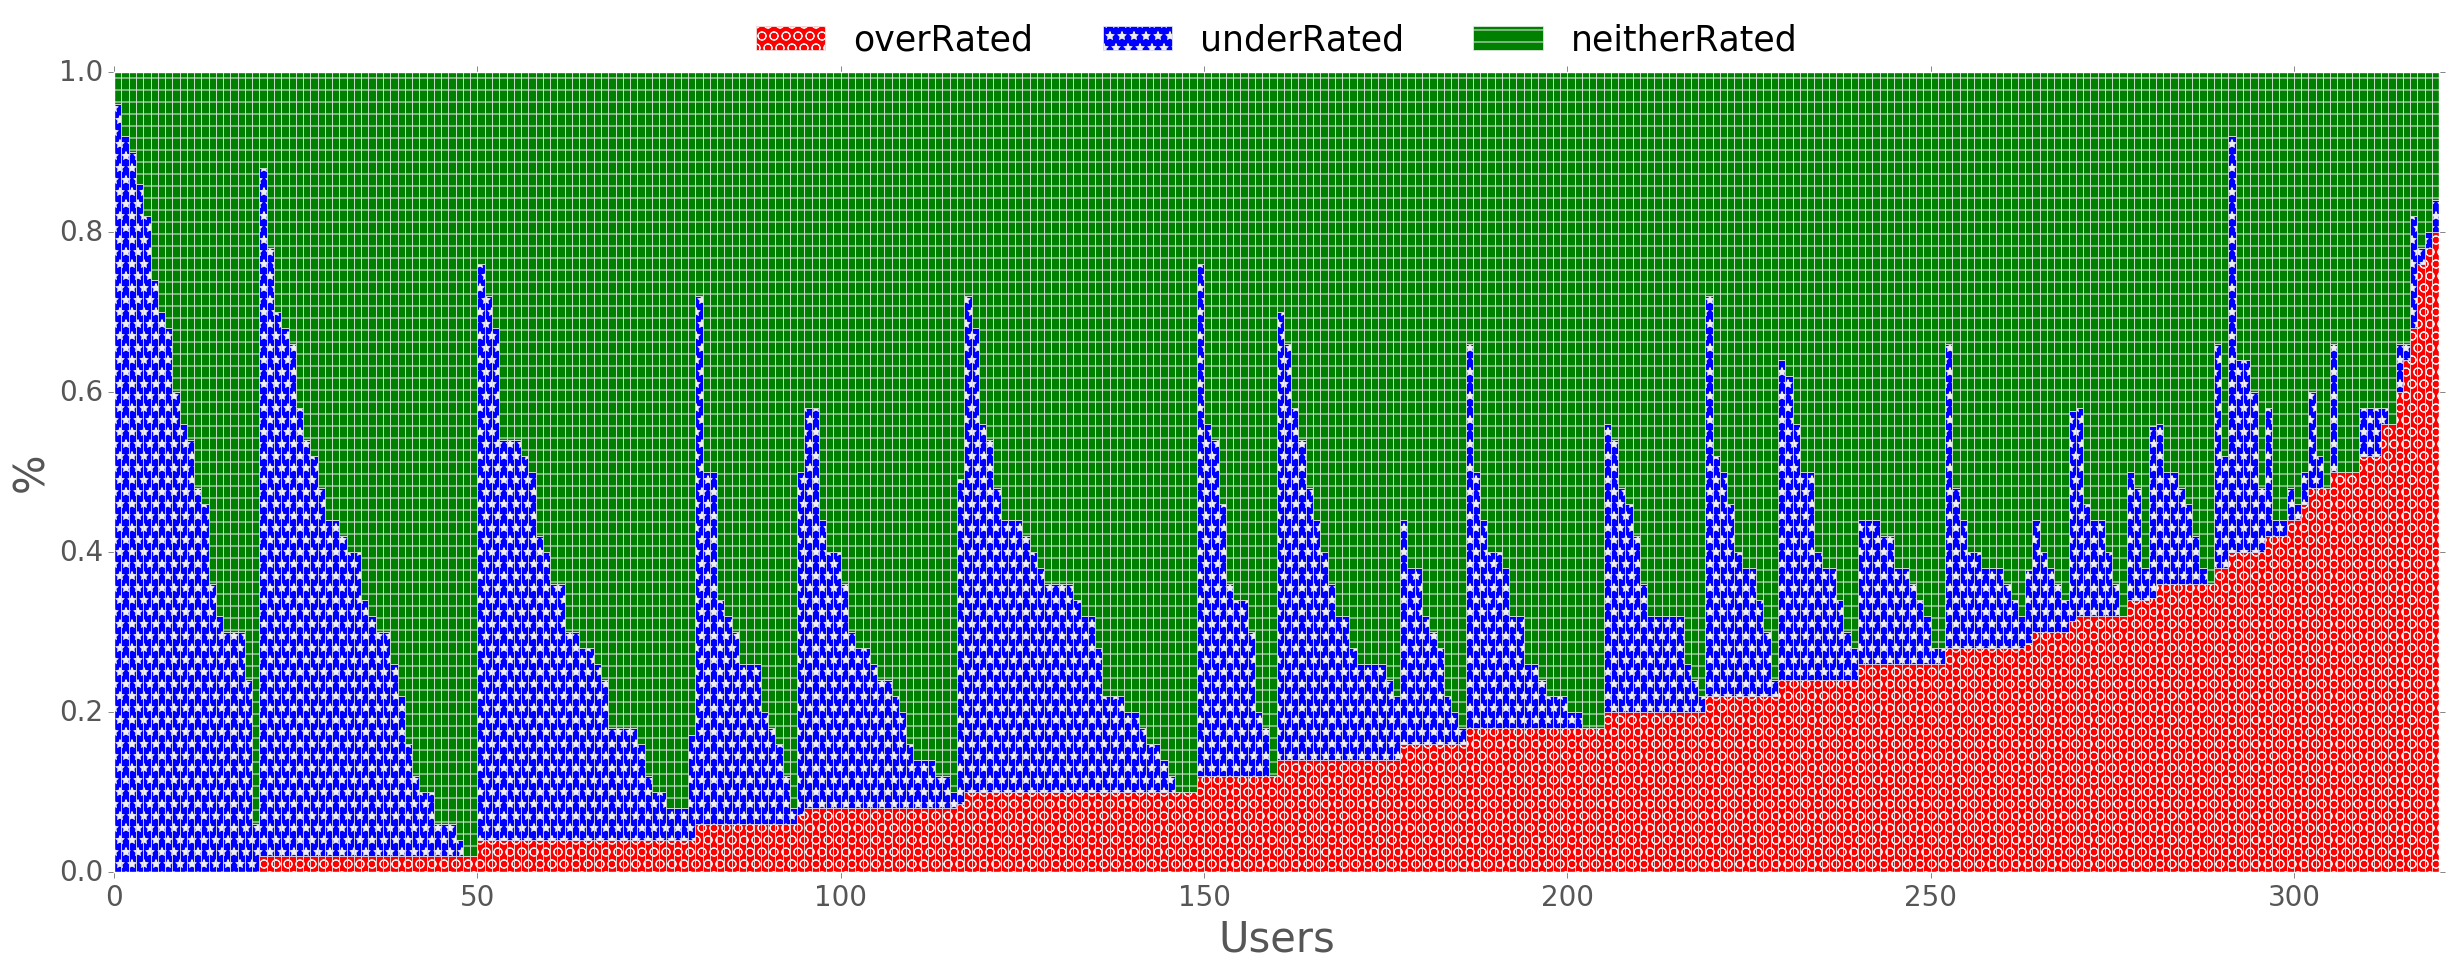

In [217]:
pcTuples.sort(key = lambda tup: tup[0])
pcTuples.sort(key = lambda tup: tup[2])
pcTuples.sort(key = lambda tup: tup[1])

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])
plt.style.use('ggplot')
f = plt.figure(figsize = (30,10))
plt.bar(x, overRatedPcs, width=1, color = 'red', label='overRated', hatch='O')
plt.bar(x, underRatedPcs, width=1, color = 'blue', bottom=overRatedPcs, label='underRated', hatch='*')
plt.bar(x, neitherRatedPcs, width=1, color='green', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)],
        label='neitherRated', hatch='-')
plt.axis("tight")
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize='25', 
           shadow=False, fancybox=False, framealpha=0)
plt.xlabel('Users', fontsize='30')
plt.ylabel('%', fontsize='30')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

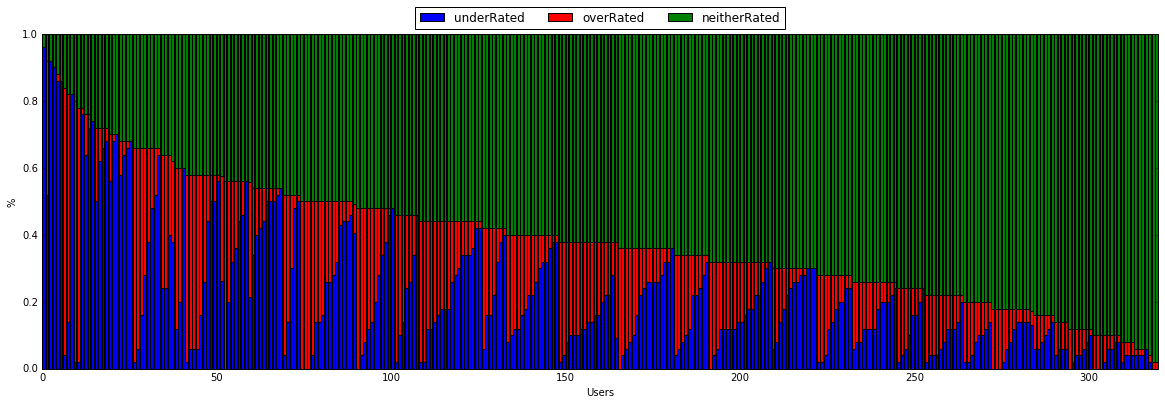

In [176]:
pcTuples.sort(key = lambda tup: tup[1])
pcTuples.sort(key = lambda tup: tup[0])
pcTuples.sort(key = lambda tup: tup[2])

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])
f = plt.figure(figsize = (20,6))
plt.bar(x, underRatedPcs, color = 'b', label='underRated')
plt.bar(x, overRatedPcs, color = 'r', bottom = underRatedPcs, label='overRated')
plt.bar(x, neitherRatedPcs, color='g', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='neitherRated')
plt.axis("tight")
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xlabel('Users')
plt.ylabel('%')

In [437]:
np.average(neitherRatedPcs), np.average(underRatedPcs), np.average(overRatedPcs)

(0.60976970609764192, 0.22023566541408551, 0.16999462848827257)

In [438]:
setsLabel = []
for user, setRatings in uSetRatings.iteritems():
    if len(setRatings) < 50:
        continue
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        setRatingType = isSetUnderOverRat(user, items, rating)
        setsLabel.append(setRatingType)

In [439]:
len(setsLabel)

16231

In [440]:
permSetsLabel = np.random.permutation(setsLabel)

In [441]:
float(len(permSetsLabel))/320

50.721875

In [447]:
def randLabels():
    permSetsLabel = np.random.permutation(setsLabel)
    uPermSetsPc = {}
    uPermPcTuples = []
    for u in range(320):
        start = u*50
        uSetsLabel = permSetsLabel[start:start+50]
        underCount = 0.0
        overCount = 0.0
        for label in uSetsLabel:
            if label == UNDER_RATED_SET:
                underCount += 1
            elif label == OVER_RATED_SET:
                overCount += 1
        neitherCount = 50.0 - (underCount + overCount)
        underPc   = underCount/50
        overPc    = overCount/50
        neitherPC = neitherCount/50
        uPermSetsPc[u] = [underPc, overPc, neitherPC]
        uPermPcTuples.append((underPc, overPc, neitherPC))
    uPermPcTuples.sort(key = lambda tup: tup[1])
    uPermPcTuples.sort(key = lambda tup: tup[0])
    uPermPcTuples.sort(key = lambda tup: tup[2])
    nUsers = len(uPermPcTuples)
    x = range(nUsers)
    underRatedPcs = []
    overRatedPcs = []
    neitherRatedPcs = []

    for pcTuple in uPermPcTuples:
        underRatedPcs.append(pcTuple[0])
        overRatedPcs.append(pcTuple[1])
        neitherRatedPcs.append(pcTuple[2])
    plt.style.use('classic')
    f = plt.figure(figsize = (20,6))
    #plt.bar(x, overRatedPcs, color = 'r', label='overRated')
    #plt.bar(x, underRatedPcs, color = 'b', bottom=overRatedPcs, label='underRated')
    plt.bar(x, underRatedPcs, color = 'b', label='underRated')
    plt.bar(x, overRatedPcs, color = 'r', bottom = underRatedPcs, label='overRated')
    plt.bar(x, neitherRatedPcs, color='g', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='neitherRated')
    plt.axis("tight")
    plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xlabel('Users')
    plt.ylabel('%')
    
    print np.average(underRatedPcs), np.average(overRatedPcs), np.average(neitherRatedPcs)
    return (underRatedPcs, overRatedPcs, neitherRatedPcs)

0.220375 0.1703125 0.6093125


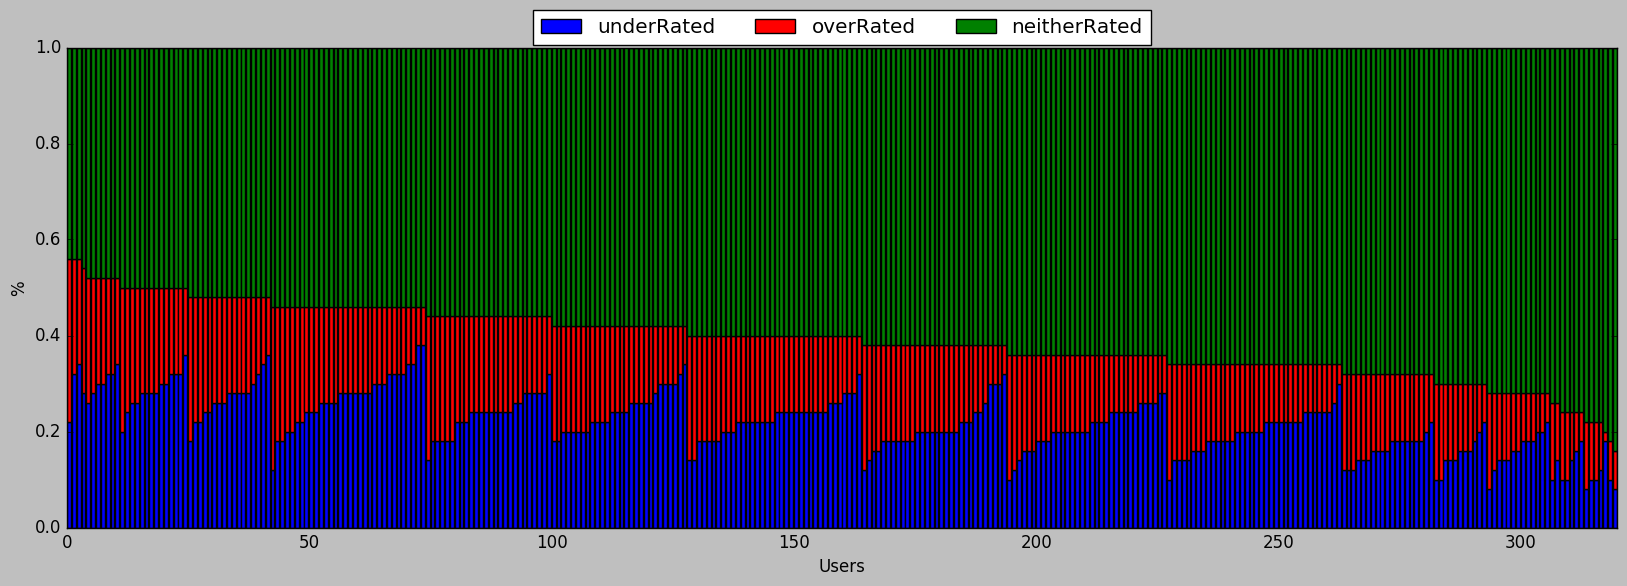

In [448]:
[randUnderRatedPcs, randOverRatedPcs, randNeitherRatedPcs] = randLabels()

0.2200625 0.169625 0.6103125


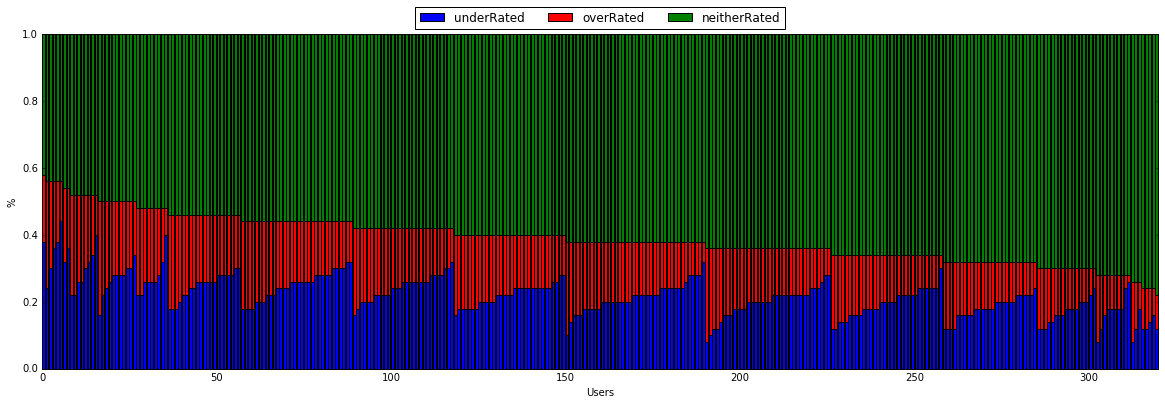

In [161]:
(randUnderRatedPcs, randOverRatedPcs, randNeitherRatedPcs) = randLabels()

In [187]:
print len(underRatedPcs), len(overRatedPcs)
diffRatedPcs = [ underRatedPcs[i] + neitherRatedPcs[i] for i in range(len(underRatedPcs))]
diffRandRatedPcs = [randUnderRatedPcs[i] + randNeitherRatedPcs[i] for i in range(len(randOverRatedPcs))]
print stats.ttest_ind(underRatedPcs, randUnderRatedPcs)
print stats.ttest_ind(overRatedPcs, randOverRatedPcs)
print stats.ttest_ind(neitherRatedPcs, randNeitherRatedPcs)
print stats.ttest_ind(diffRatedPcs, diffRandRatedPcs)

320 320
Ttest_indResult(statistic=0.015179086364678369, pvalue=0.98789405177093248)
Ttest_indResult(statistic=-0.056941637710800949, pvalue=0.95460951412952588)
Ttest_indResult(statistic=0.029842875289157789, pvalue=0.97620169715892402)
Ttest_indResult(statistic=0.056941637710804079, pvalue=0.95460951412952344)


In [164]:
itemRatingPair = {}
for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        setRatingType = isSetUnderOverRat(user, items, rating)
        for item in items:
            itemRating = uiRatings[user][item]
            if item not in itemRatingPair:
                itemRatingPair[item] = {}
            if itemRating not in itemRatingPair[item]:
                itemRatingPair[item][itemRating] = [0.0, 0.0, 0.0, 0.0] #[neitherCt, unCt, ovCt, total]
            itemRatingPair[item][itemRating][setRatingType] += 1
            itemRatingPair[item][itemRating][3] += 1
            
for item, ratingNCount in itemRatingPair.iteritems():
    for rating, counts in ratingNCount.iteritems():
        itemRatingPair[item][rating][0] = itemRatingPair[item][rating][0]/itemRatingPair[item][rating][3]
        itemRatingPair[item][rating][1] = itemRatingPair[item][rating][1]/itemRatingPair[item][rating][3]
        itemRatingPair[item][rating][2] = itemRatingPair[item][rating][2]/itemRatingPair[item][rating][3]

neitherPc = []
overPc = []
underPc = []
for item, ratingNCount in itemRatingPair.iteritems():
    for rating, counts in ratingNCount.iteritems():
        nSets = counts[3]
        if nSets >= 5:
            neitherPc.append(counts[NEITHER_RATED_SET])
            underPc.append(counts[UNDER_RATED_SET])
            overPc.append(counts[OVER_RATED_SET])
print 'avg neitherPc: ', np.average(neitherPc)
print 'avg underPc: ', np.average(underPc)
print 'avg overPc: ', np.average(overPc)

avg neitherPc:  0.604345726357
avg underPc:  0.222040770152
avg overPc:  0.173613503491


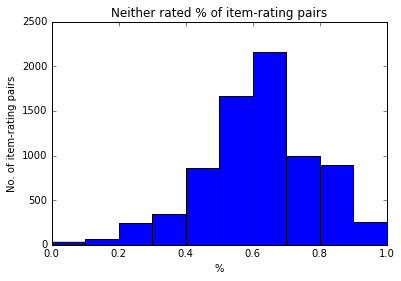

In [165]:
plt.hist(neitherPc)
plt.xlabel('%')
plt.ylabel('No. of item-rating pairs')
plt.title('Neither rated % of item-rating pairs')

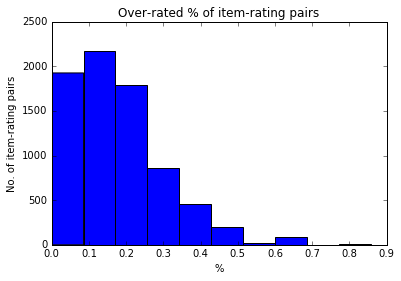

In [166]:
plt.hist(overPc);
plt.xlabel('%')
plt.ylabel('No. of item-rating pairs')
plt.title('Over-rated % of item-rating pairs')

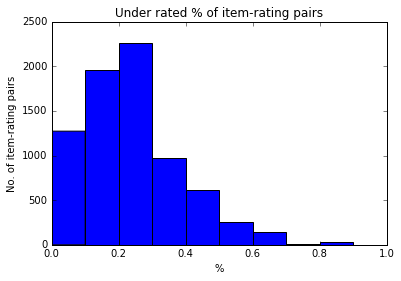

In [167]:
plt.hist(underPc);
plt.xlabel('%')
plt.ylabel('No. of item-rating pairs')
plt.title('Under rated % of item-rating pairs')

In [330]:
underSetCt = 0.0
loUnderCt = 0.0
hiUnderCt = 0.0

overSetCt = 0.0
loOverCt = 0.0
hiOverCt = 0.0

neitherSetCt = 0.0

for item, ratingNCount in itemRatingPair.iteritems():
    for rating, counts in ratingNCount.iteritems():
        nSets = counts[3]
        if nSets >= 5:
            if counts[UNDER_RATED_SET] > 0.22:
                underSetCt += 1
                if rating > 3:
                    hiUnderCt += 1
                else:
                    loUnderCt += 1
            if counts[OVER_RATED_SET] > 0.17:
                overSetCt += 1
                if rating > 3:
                    hiOverCt += 1
                else:
                    loOverCt += 1
                    
print "underRated itemRating pairs: ", underSetCt, "low rated: ", loUnderCt/underSetCt, 'high rated: ', hiUnderCt/underSetCt
print "overRated  itemRating pairs: ", overSetCt, "low rated: ", loOverCt/overSetCt, "high rated: ", hiOverCt/overSetCt

underRated itemRating pairs:  3322.0 low rated:  0.336243226972 high rated:  0.663756773028
overRated  itemRating pairs:  3417.0 low rated:  0.419959028387 high rated:  0.580040971613


In [182]:
stats.f_oneway(randOverRatedPcs, overRatedPcs)

F_onewayResult(statistic=0.0032423501050771342, pvalue=0.95460951412998996)

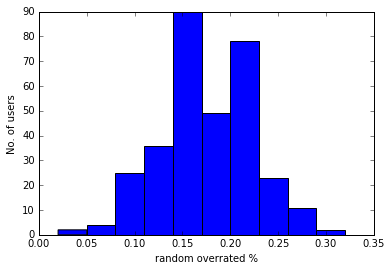

In [217]:
plt.hist(randOverRatedPcs)
plt.xlabel('random overrated %')
plt.ylabel('No. of users')

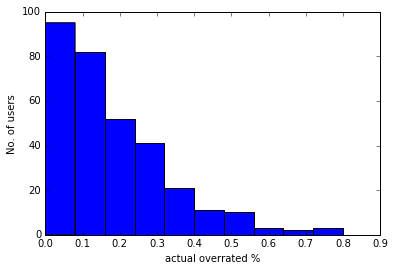

In [219]:
plt.hist(overRatedPcs)
plt.xlabel('actual overrated %')
plt.ylabel('No. of users')

In [191]:
np.average(overRatedPcs), np.average(randOverRatedPcs)

(0.16999462848827257, 0.17050000000000001)

In [165]:
np.std(overRatedPcs), np.std(randOverRatedPcs)
stats.ks_2samp(overRatedPcs, randOverRatedPcs)
stats.shapiro(randOverRatedPcs)
stats.mannwhitneyu(overRatedPcs, randOverRatedPcs)
stats.ks_2samp(overRatedPcs, randOverRatedPcs)

Ks_2sampResult(statistic=0.34375, pvalue=3.4946932070183747e-17)

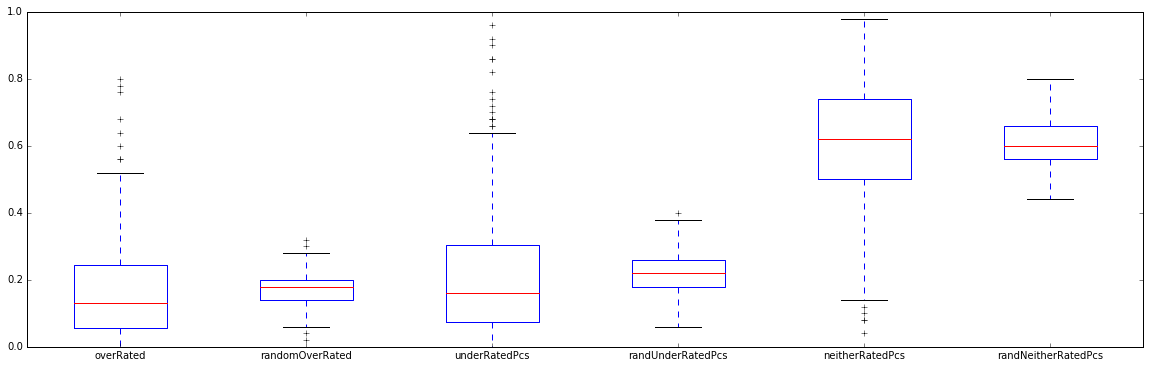

In [215]:
f = plt.figure(figsize=(20,6))
fig, ax = plt.subplots(1,1, figsize=(20,6))
ax.boxplot([overRatedPcs, randOverRatedPcs, underRatedPcs, randUnderRatedPcs, neitherRatedPcs, randNeitherRatedPcs])
ax.set_xticklabels(['overRated', 'randomOverRated', 'underRatedPcs', 'randUnderRatedPcs', 'neitherRatedPcs', 'randNeitherRatedPcs'])

In [138]:
def getOldestTstampSet(user, items):
    tstamps = []
    for item in items:
        tstamps.append(uiTstamp[user][item])
    tstamps.sort()
    return tstamps[0]

def getAvgTstampSet(user, items, latestTStamp):
    tstamps = []
    for item in items:
        tstamps.append((latestTstamp - uiTstamp[user][item]).total_seconds())
    return np.average(tstamps)

def getMedianTstampSet(user, items):
    tstamps = []
    for item in items:
        tstamps.append(uiTstamp[user][item])
    tstamps.sort()
    return tstamps[2]


def getOldTstampSets(userSetRatings):
    oldTstamps = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            oldTstamps.append(getOldestTstampSet(user, items))
    return oldTstamps

def getOldTstampSetsDiff(userSetRatings):
    diffTstamps = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            oldestTstamp = getOldestTstampSet(user, items)
            latestTstamp = usersLatestTstamp[user]
            diffTstamps.append((latestTstamp  - oldestTstamp).total_seconds())
    return diffTstamps

def getOldTstampSetsLatestDiff(userSetRatings):
    diffTstamps = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            oldestTstamp = getOldestTstampSet(user, items)
            latestTstamp = datetime.datetime.now()
            diffTstamps.append((latestTstamp  - oldestTstamp).total_seconds())
    return diffTstamps

def getUsersLatestTstamp():
    userLatestTstamp = {}
    for user, itemTstamp in uiTstamp.iteritems():
        uStamps = itemTstamp.values()
        uStamps.sort()
        userLatestTstamp[user] = uStamps[-1]
    return userLatestTstamp

In [276]:
uUnderRatedTstamps = getOldTstampSets(uUnderRatedSetRatings)
uOverRatedTstamps = getOldTstampSets(uOverRatedSetRatings)
uNeitherRatedTstamps = getOldTstampSets(uNeitherRatedSetRatings)

uUnderRatedTstampsDiff = getOldTstampSetsDiff(uUnderRatedSetRatings)
uOverRatedTstampsDiff = getOldTstampSetsDiff(uOverRatedSetRatings)
uNeitherRatedTstampsDiff = getOldTstampSetsDiff(uNeitherRatedSetRatings)

uUnderRatedTstampsLatestDiff = getOldTstampSetsLatestDiff(uUnderRatedSetRatings)
uOverRatedTstampsLatestDiff = getOldTstampSetsLatestDiff(uOverRatedSetRatings)
uNeitherRatedTstampsLatestDiff = getOldTstampSetsLatestDiff(uNeitherRatedSetRatings)

In [255]:
usersLatestTstamp = getUsersLatestTstamp()

In [265]:
uUnderRatedTstampsDiff[:3]

[9303541.0, 9312496.0, 9310307.0]

In [269]:
np.average(uUnderRatedTstampsDiff)/(3600*24), np.average(uOverRatedTstampsDiff)/(3600*24), np.average(uNeitherRatedTstampsDiff)/(3600*24)

(1734.2098617399263, 1361.1554936786044, 1369.616190470407)

In [270]:
stats.ttest_ind(uUnderRatedTstampsDiff, uOverRatedTstampsDiff)

Ttest_indResult(statistic=10.868173617063897, pvalue=2.2037049496178921e-27)

In [271]:
stats.ttest_ind(uOverRatedTstampsDiff, uNeitherRatedTstampsDiff)

Ttest_indResult(statistic=-0.30539158510113773, pvalue=0.76007070048876035)

In [273]:
stats.ttest_ind(uUnderRatedTstampsDiff, uNeitherRatedTstampsDiff)

Ttest_indResult(statistic=14.044730770507627, pvalue=1.2407885362481827e-44)

In [277]:
np.average(uUnderRatedTstampsLatestDiff)/(3600*24), np.average(uOverRatedTstampsLatestDiff)/(3600*24), np.average(uNeitherRatedTstampsLatestDiff)/(3600*24)

(1841.2685534553516, 1467.8213540153199, 1456.8060104256751)

In [279]:
print stats.ttest_ind(uUnderRatedTstampsLatestDiff, uOverRatedTstampsLatestDiff)
print stats.ttest_ind(uNeitherRatedTstampsLatestDiff, uOverRatedTstampsLatestDiff)
print stats.ttest_ind(uUnderRatedTstampsLatestDiff, uNeitherRatedTstampsLatestDiff)

Ttest_indResult(statistic=10.723759363233757, pvalue=1.0454089944224831e-26)
Ttest_indResult(statistic=-0.3944279295091444, pvalue=0.69326879303397637)
Ttest_indResult(statistic=14.653978147093945, pvalue=2.0453756568057031e-48)


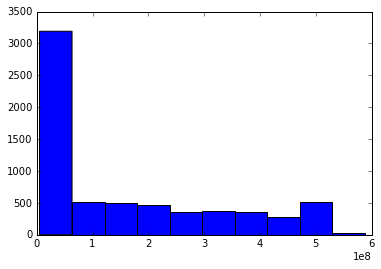

In [283]:
plt.hist(uUnderRatedTstampsLatestDiff);

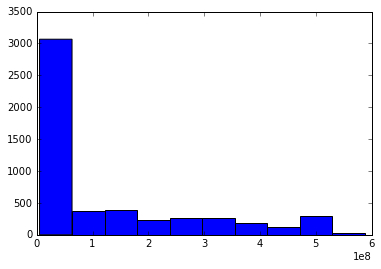

In [289]:
plt.hist(uOverRatedTstampsLatestDiff);

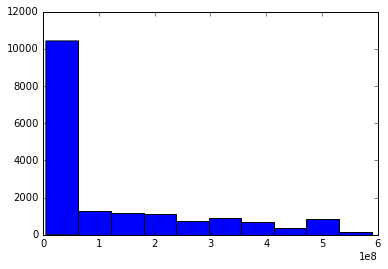

In [288]:
plt.hist(uNeitherRatedTstampsLatestDiff);

In [317]:
nSets = 0.0
nOldSets = 0.0
nOldUnderRatedSets = 0.0
nOldOverRatedSets = 0.0
nOldNeitherRatedSets = 0.0
uOldPcs = {}
for user, setRatings in uSetRatings.iteritems():
    uOldSets = 0.0
    uOldUnderRatedSets = 0.0
    uOldOverRatedSets = 0.0
    uOldNeitherRatedSets = 0.0
    for setRating in setRatings:
        nSets += 1
        items = setRating[0]
        rating = setRating[1]
        setRatingType = isSetUnderOverRat(user, items, rating)
        oldTstamp = getOldestTstampSet(user, items)
        tdiff = (usersLatestTstamp[user] - oldTstamp).total_seconds()
        diffDays = tdiff/(3600*24)
        if diffDays > 1500:
            #old movie in set
            nOldSets += 1
            uOldSets += 1
            if setRatingType == UNDER_RATED_SET:
                nOldUnderRatedSets += 1
                uOldUnderRatedSets += 1
            elif setRatingType == OVER_RATED_SET:
                nOldOverRatedSets += 1
                uOldOverRatedSets += 1
            else:
                nOldNeitherRatedSets += 1
                uOldNeitherRatedSets += 1
    if uOldSets > 0:
        uOldPcs[user] = [uOldUnderRatedSets/uOldSets, uOldOverRatedSets/uOldSets, uOldNeitherRatedSets/uOldSets, uOldSets]

In [295]:
#1370
print 'nOldSets: ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets:  10402.0
nOldUnderRatedSets:  0.269371274755
nOldOverRatedSets:  0.165160546049
nOldNeitherRatedSets:  0.565468179196


In [298]:
print 'nOldSets (1500days and old): ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets (1500days and old):  9960.0
nOldUnderRatedSets:  0.273493975904
nOldOverRatedSets:  0.160040160643
nOldNeitherRatedSets:  0.566465863454


In [300]:
print 'nOldSets (2000 days and old): ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets (2000 days and old):  8505.0
nOldUnderRatedSets:  0.279717813051
nOldOverRatedSets:  0.158612580835
nOldNeitherRatedSets:  0.561669606114


In [302]:
print 'nOldSets (3000 days and old): ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets (3000 days and old):  5844.0
nOldUnderRatedSets:  0.274640657084
nOldOverRatedSets:  0.170431211499
nOldNeitherRatedSets:  0.554928131417


In [318]:
len(uOldPcs)

247

In [319]:
uOldPcsUn = [tup[0] for tup in uOldPcs.values()]
uOldPcsOv = [tup[1] for tup in uOldPcs.values()]
uOldPcsNe = [tup[2] for tup in uOldPcs.values()]

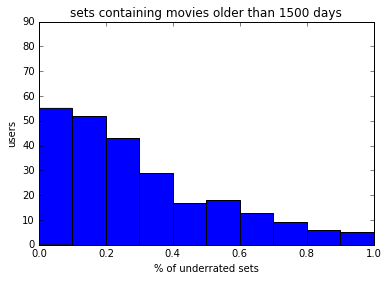

In [327]:
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
ax.hist(uOldPcsUn)
ax.set_ylim(0,90)
ax.set_xlabel('% of underrated sets')
ax.set_ylabel('users')
ax.set_title('sets containing movies older than 1500 days')

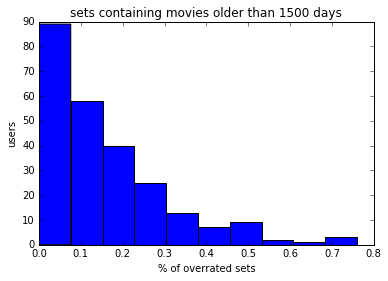

In [328]:
plt.hist(uOldPcsOv);
plt.xlabel('% of overrated sets')
plt.ylabel('users')
plt.title('sets containing movies older than 1500 days')

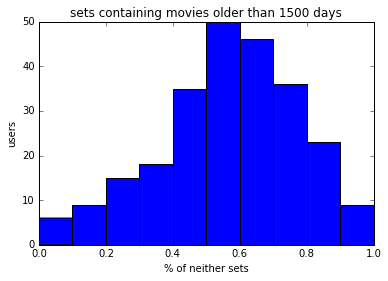

In [329]:
plt.hist(uOldPcsNe);
plt.xlabel('% of neither sets')
plt.ylabel('users')
plt.title('sets containing movies older than 1500 days')

In [386]:
itemRatingPairUnSets = []
itemRatingPairOvSets = []
loUnderCt = 0
hiOverCt = 0
for item, ratingNCount in itemRatingPair.iteritems():
    for rating, counts in ratingNCount.iteritems():
        nSets = counts[3]
        if nSets >= 10:
            #if counts[UNDER_RATED_SET] > 0.22:
                if rating < 3:
                    itemRatingPairUnSets.append((item,rating))
                    loUnderCt += 1
            #if counts[OVER_RATED_SET] > 0.17:
                if rating > 3:
                    hiOverCt += 1
                    itemRatingPairOvSets.append((item, rating))

In [387]:
len(itemRatingPairUnSets)

208

In [388]:
len(itemRatingPairOvSets)

2394

In [403]:
itemUnCounts = {}
for (item, rating) in itemRatingPairUnSets:
    counts = itemRatingPair[item][rating]
    if item not in itemUnCounts:
        itemUnCounts[item] = [0.0, 0.0, 0.0, 0.0]
    itemUnCounts[item][UNDER_RATED_SET] += counts[UNDER_RATED_SET]*counts[3]
    itemUnCounts[item][OVER_RATED_SET] += counts[OVER_RATED_SET]*counts[3]
    itemUnCounts[item][NEITHER_RATED_SET] += counts[NEITHER_RATED_SET]*counts[3]
    itemUnCounts[item][3] += counts[3]

unItems = []
for item, counts in itemUnCounts.iteritems():
    itemUnCounts[item][UNDER_RATED_SET] = itemUnCounts[item][UNDER_RATED_SET]/itemUnCounts[item][3]
    if itemUnCounts[item][UNDER_RATED_SET] > 0.4:
        unItems.append(item)
    itemUnCounts[item][OVER_RATED_SET] = itemUnCounts[item][OVER_RATED_SET]/itemUnCounts[item][3]
    itemUnCounts[item][NEITHER_RATED_SET] = itemUnCounts[item][NEITHER_RATED_SET]/itemUnCounts[item][3]
    

In [404]:
itemOvCounts = {}
for (item, rating) in itemRatingPairOvSets:
    counts = itemRatingPair[item][rating]
    if item not in itemOvCounts:
        itemOvCounts[item] = [0.0, 0.0, 0.0, 0.0]
    itemOvCounts[item][UNDER_RATED_SET] += counts[UNDER_RATED_SET]*counts[3]
    itemOvCounts[item][OVER_RATED_SET] += counts[OVER_RATED_SET]*counts[3]
    itemOvCounts[item][NEITHER_RATED_SET] += counts[NEITHER_RATED_SET]*counts[3]
    itemOvCounts[item][3] += counts[3]

ovItems = []
for item, counts in itemOvCounts.iteritems():
    itemOvCounts[item][UNDER_RATED_SET] = itemOvCounts[item][UNDER_RATED_SET]/itemOvCounts[item][3]
    itemOvCounts[item][OVER_RATED_SET] = itemOvCounts[item][OVER_RATED_SET]/itemOvCounts[item][3]
    if itemOvCounts[item][OVER_RATED_SET] > 0.4:
        ovItems.append(item)
    itemOvCounts[item][NEITHER_RATED_SET] = itemOvCounts[item][NEITHER_RATED_SET]/itemOvCounts[item][3]

In [393]:
len(unItems), len(ovItems)

(1, 2)

In [380]:
set(unItems).intersection(set(ovItems))

set()

In [405]:
unSetCt = 0
unTotalSetCt = 0
ovSetCt = 0
ovTotalSetCt = 0
for item in unItems:
    unSetCt += itemUnCounts[item][3]*itemUnCounts[item][UNDER_RATED_SET]
    unTotalSetCt += itemUnCounts[item][3]
for item in ovItems:    
    ovSetCt += itemOvCounts[item][3]*itemOvCounts[item][OVER_RATED_SET]
    ovTotalSetCt += itemOvCounts[item][3]
print len(unItems), ' items present in', unSetCt, ' underRatedSets ', ' unTotalSetCt ', unTotalSetCt
print len(ovItems), ' items present in', ovSetCt, ' overRatedSets ', ' ovTotalSetCt ', ovTotalSetCt
print unItems
print ovItems

8  items present in 51.0  underRatedSets   unTotalSetCt  107.0
8  items present in 51.0  overRatedSets   ovTotalSetCt  107.0
[541, 586, 2683, 8360, 72407, 6539, 109487, 5266]
[48, 2096, 307, 6979, 4975, 1215, 44761, 104211]


In [406]:
itemFreq = {}
for user, itemRatings in uiRatings.iteritems():
    for item, rating in itemRatings.iteritems():
        if item not in itemFreq:
            itemFreq[item] = 0
        itemFreq[item] += 1

In [415]:
for item in unItems:
    print itemNames[item],',',itemFreq[item]

Blade Runner , 489
Home Alone , 367
Austin Powers: The Spy Who Shagged Me , 323
Shrek 2 , 430
The Twilight Saga: New Moon , 109
Pirates of the Caribbean: The Curse of the Black Pearl , 599
Interstellar , 540
Panic Room , 226


In [416]:
for item in ovItems:
    print itemNames[item],',',itemFreq[item]

Pocahontas , 167
Sleeping Beauty , 117
Three Colors: Blue , 105
WarGames , 154
Vanilla Sky , 242
Army of Darkness , 165
Brick , 120
We're the Millers , 132


In [409]:
itemNames = {
    541:"Blade Runner", 586:"Home Alone", 2683:"Austin Powers: The Spy Who Shagged Me",
    8360:"Shrek 2", 72407:"The Twilight Saga: New Moon", 6539:"Pirates of the Caribbean: The Curse of the Black Pearl",
    109487:"Interstellar", 5266:"Panic Room", 48:"Pocahontas", 2096:"Sleeping Beauty", 307:"Three Colors: Blue",
    6979:"WarGames", 4975:"Vanilla Sky", 1215:"Army of Darkness", 44761:"Brick",
    104211:"We're the Millers"
}

In [417]:
unItems = set(unItems)
ovItems = set(ovItems)

In [427]:
unPairFreq = {}
for user, setRatings in uUnderRatedSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        foundItems = set(items) & unItems
        foundList = list(foundItems)
        foundList.sort()
        if len(foundList) >= 2:
            if tuple(foundList) not in unPairFreq:
                unPairFreq[tuple(foundList)] = 0
            unPairFreq[tuple(foundList)] += 1

In [419]:
len(uUnderRatedSetRatings)

731

In [428]:
unPairFreq

{(5266, 8360): 1}

In [431]:
ovPairFreq = {}
for user, setRatings in uOverRatedSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        foundItems = set(items) & ovItems
        foundList = list(foundItems)
        foundList.sort()
        if len(foundList) >= 2:
            if tuple(foundList) not in ovPairFreq:
                ovPairFreq[tuple(foundList)] = 0
            ovPairFreq[tuple(foundList)] += 1

In [432]:
ovPairFreq

{}

In [438]:
diff = 0.0
nUnSets = 0
diffs = []
for user, setRatings in uUnderRatedSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        avgRat = avgSetRat(user, items)
        diff += (avgRat - rating)
        diffs.append(avgRat - rating)
        nUnSets += 1
print diff/nUnSets
        

0.874570080657


In [441]:
diff = 0.0
nOvSets = 0
diffs = []
for user, setRatings in uOverRatedSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        avgRat = avgSetRat(user, items)
        diff += (avgRat - rating)
        diffs.append(avgRat - rating)
        nOvSets += 1
print diff/nOvSets

-0.761187739464


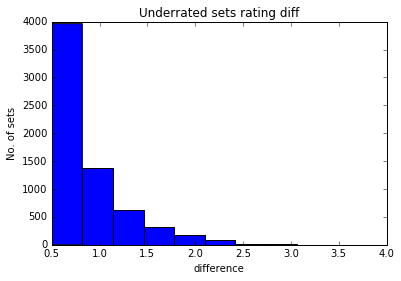

In [440]:
plt.hist(diffs)
plt.xlabel('difference')
plt.ylabel('No. of sets')
plt.title('Underrated sets rating diff')

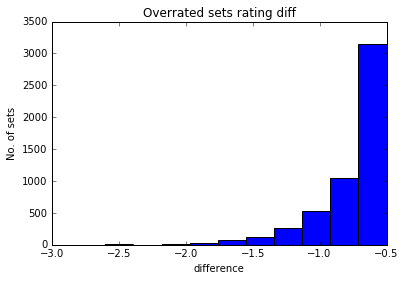

In [442]:
plt.hist(diffs)
plt.xlabel('difference')
plt.ylabel('No. of sets')
plt.title('Overrated sets rating diff')

(array([   1.,    0.,  223.,    1.,    0.,    0.,    0.,    0.,    0.,    3.]),
 array([ 179. ,  208.3,  237.6,  266.9,  296.2,  325.5,  354.8,  384.1,
         413.4,  442.7,  472. ]),
 <a list of 10 Patch objects>)

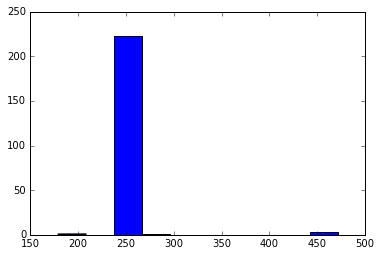

In [7]:
uRatCount = {}
with open('/home/grad02/mohit/data/movielens/setRatings/split_50p/train.csr', 'r') as  f:
    u = 0
    for line in f:
        cols = line.strip().split()
        if len(cols) > 0:
            uRatCount[u] = len(cols)/2
        u += 1
plt.hist(uRatCount.values())

(array([   1.,    0.,  223.,    1.,    0.,    0.,    0.,    0.,    0.,    3.]),
 array([ 129. ,  158.3,  187.6,  216.9,  246.2,  275.5,  304.8,  334.1,
         363.4,  392.7,  422. ]),
 <a list of 10 Patch objects>)

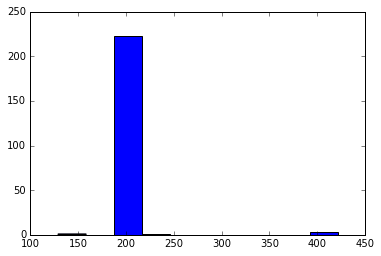

In [8]:
uRatCount = {}
with open('/home/grad02/mohit/data/movielens/setRatings/split_50p/train_50.csr', 'r') as  f:
    u = 0
    for line in f:
        cols = line.strip().split()
        if len(cols) > 0:
            uRatCount[u] = len(cols)/2
        u += 1
plt.hist(uRatCount.values())

In [9]:
import random

In [69]:
itemSz = []
with open('split5/testCount.txt', 'r') as f:
    for line in f:
        cols = line.strip().split()
        itemSz.append(int(cols[1]))

(array([   1.,  208.,   47.,   36.,   11.,   12.,   13.,   10.,    8.,   18.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.]),
 <a list of 10 Patch objects>)

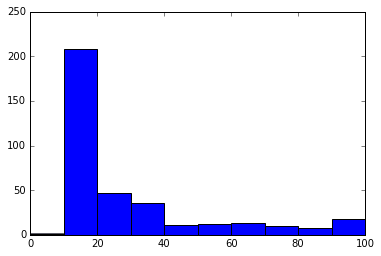

In [70]:
plt.hist(itemSz, range=(0,100))

In [71]:
lo10Ct = 0
for sz in itemSz:
    if sz <= 10:
        lo10Ct += 1
lo10Ct

25

lo10C

In [72]:
min(itemSz), len(itemSz)

(9, 817)

In [6]:
ratedItems = set([])
for user, itemRatings in uiRatings.iteritems():
    for item, rating in itemRatings.iteritems():
        ratedItems.add(item)

In [11]:
len(uiRatings), len(ratedItems), len(uSetRatings)

(926, 13225, 854)

In [154]:
setItems = set([])
ratings = []
ratingCount = {}
userSetCount = []
userMeanRating = {}
for user, setRatings in uSetRatings.iteritems():
    userMeanRating[user] = 0.0
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        userMeanRating[user] += rating
        ratings.append(rating)
        if rating not in ratingCount:
            ratingCount[rating] = 0
        ratingCount[rating] += 1
        for item in items:
            setItems.add(item)
    userMeanRating[user] = userMeanRating[user]/len(setRatings)
    userSetCount.append(len(setRatings))

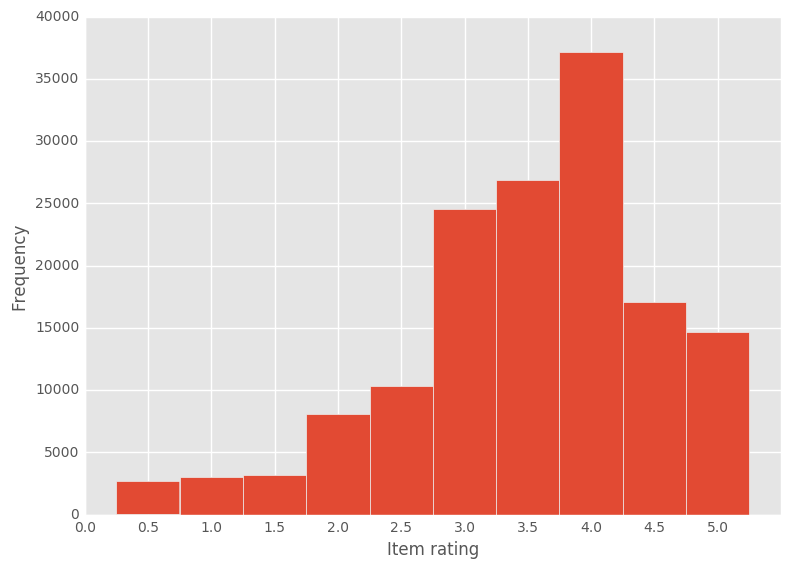

In [175]:
itemRatings = []
#for user, iRatings in uiRatings.iteritems():
#    itemRatings += iRatings.values()
for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        for item in items:
            itemRatings.append(uiRatings[user][item])

data = np.array(itemRatings)
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlim((0,5.5))
plt.xlabel('Item rating')
plt.ylabel('Frequency')

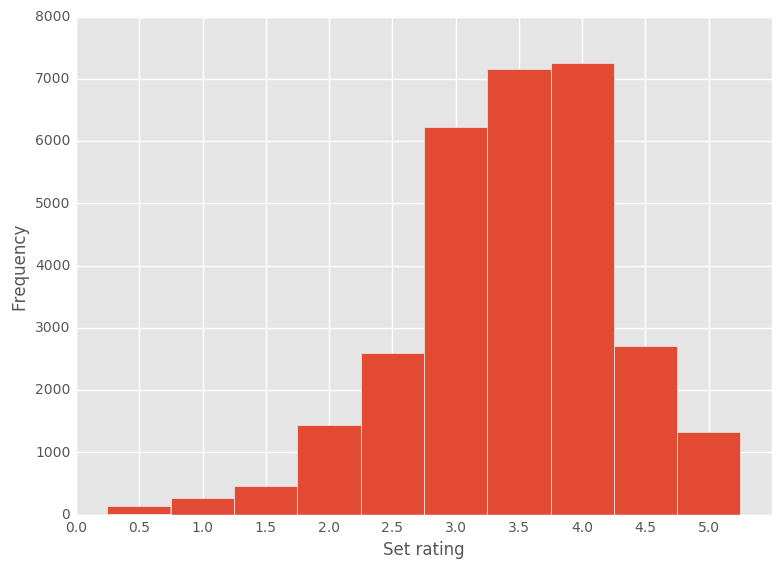

In [164]:
data = ratings
data = np.array(data)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlim((0,5.5))
plt.xlabel('Set rating')
plt.ylabel('Frequency')

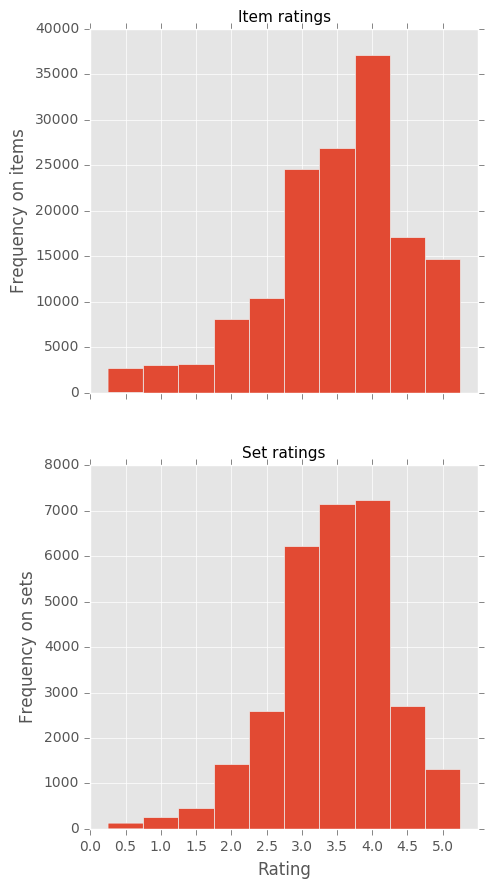

In [315]:
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
f, axarr = plt.subplots(2, sharex=True, figsize=(5,10))

data = ratings
data = np.array(data)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
#plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
#plt.xticks(np.arange(0, 5.5, 0.5))
#plt.xlim((0,5.5))
#plt.xlabel('Set rating')
#plt.ylabel('Frequency')

axarr[1].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
axarr[1].set_ylabel('Frequency on sets')
axarr[1].set_xlabel('Rating')
axarr[1].set_xticks(np.arange(0, 5.5, 0.5))
axarr[1].set_xlim((0, 5.5))
axarr[1].set_title('Set ratings', fontsize=11)
#axarr[2].set_xticklabels(['-1', '-.75', '-.5', '-.25', '0', '.25', '.5', '.75', '1'])

data = np.array(itemRatings)
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
axarr[0].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
axarr[0].set_xticks(np.arange(0, 5.5, 0.5))
axarr[0].set_ylabel('Frequency on items')
axarr[0].set_xlim((0, 5.5))
axarr[0].set_title('Item ratings', fontsize=11)

#axarr[1].bar(range(len(buckets)), bucketsDev, width=1)
#axarr[1].set_ylabel('Diversity')
#axarr[0].bar(range(len(buckets)), bucketsTstamp, width=1)
#axarr[0].set_ylabel('Months')



In [165]:
ratingCount
ratLabels = []
ratCount = []
ks = ratingCount.keys()
ks.sort()
for k in ks:
    ratLabels.append(k)
    ratCount.append(ratingCount[k])
ratLabels, ratCount

([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
 [128, 270, 451, 1438, 2592, 6217, 7149, 7245, 2699, 1327])

In [42]:
left_of_first_bin, right_of_last_bin
np.arange(left_of_first_bin, right_of_last_bin + d, d)

array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,
        4.75,  5.25])

In [294]:
#stats.ks_2samp(ratings, itemRatings)
#stats.mannwhitneyu(ratings, itemRatings)
#stats.f_oneway(ratings, itemRatings)
help(stats.mannwhitneyu)

Help on function mannwhitneyu in module scipy.stats.stats:

mannwhitneyu(x, y, use_continuity=True)
    Computes the Mann-Whitney rank test on samples x and y.
    
    Parameters
    ----------
    x, y : array_like
        Array of samples, should be one-dimensional.
    use_continuity : bool, optional
            Whether a continuity correction (1/2.) should be taken into
            account. Default is True.
    
    Returns
    -------
    statistic : float
        The Mann-Whitney statistics.
    pvalue : float
        One-sided p-value assuming a asymptotic normal distribution.
    
    Notes
    -----
    Use only when the number of observation in each sample is > 20 and
    you have 2 independent samples of ranks. Mann-Whitney U is
    significant if the u-obtained is LESS THAN or equal to the critical
    value of U.
    
    This test corrects for ties and by default uses a continuity correction.
    The reported p-value is for a one-sided hypothesis, to get the two-sided
  

(array([   2.,    0.,    8.,   28.,   80.,  179.,  245.,  216.,   72.,   24.]),
 array([ 0.9 ,  1.31,  1.72,  2.13,  2.54,  2.95,  3.36,  3.77,  4.18,
         4.59,  5.  ]),
 <a list of 10 Patch objects>)

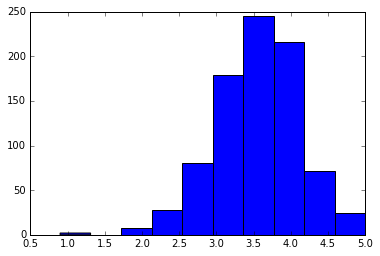

In [52]:
plt.hist(userMeanRating.values())

In [54]:
np.histogram(userMeanRating.values(), bins = range(6))

(array([  1,   5, 124, 539, 185]), array([0, 1, 2, 3, 4, 5]))

(array([   0.,    1.,    1.,    4.,   29.,   95.,  238.,  301.,  149.,
          35.,    1.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5]),
 <a list of 11 Patch objects>)

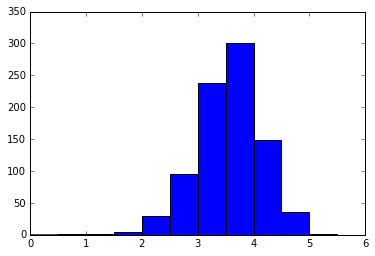

In [73]:
plt.hist(userMeanRating.values(), bins=np.arange(0,6,.5))


In [152]:
plt.hist(userMeanRating.values(), bins=np.arange(0,5.5,.5))
plt.xlabel('Mean rating')
plt.ylabel('Number of users')
plt.xlim((1.5,5))

NameError: name 'userMeanRating' is not defined

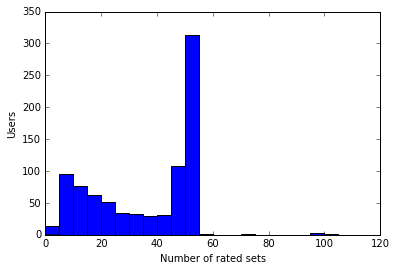

In [85]:
plt.hist(userSetCount, bins=range(0, 120, 5))
plt.xlabel('Number of rated sets')
plt.ylabel('Users')

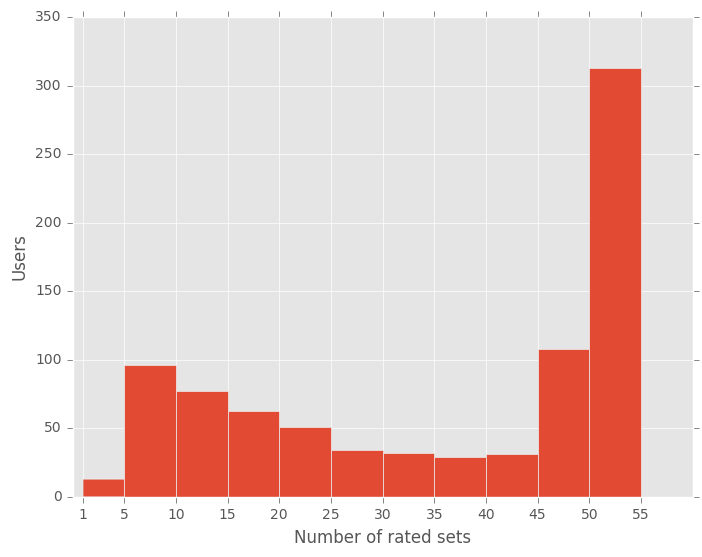

In [278]:
#plt.figure(figsize=(50,25))
#plt.hist(userSetCount, bins=[1] + range(5,60, 5), align='left')
plt.style.use('ggplot')
plt.hist(userSetCount, bins=[1] + range(5,60, 5))#, align='left')
plt.xlim((0,60))
plt.xticks([1] + range(5,60, 5))
plt.xlabel('Number of rated sets')
plt.ylabel('Users')

(array([  13.,   96.,   77.,   63.,   51.,   34.,   32.,   29.,   31.,
         108.,  313.,    2.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    3.,    1.,    0.,    0.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115]),
 <a list of 23 Patch objects>)

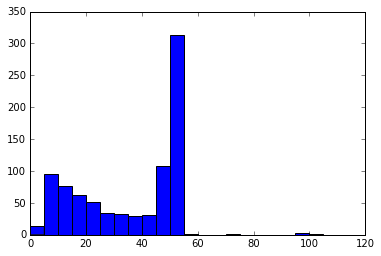

In [130]:
plt.hist(userSetCount, bins=[0] + range(5,120, 5))

In [122]:
len(userSetCount)

854

In [15]:
def compBuckProp(listSetSign):
    count = 0.0
    sumDiff = 0.0
    sumDev = 0.0
    sumTstampDiff = 0.0
    for setSign in listSetSign:
        diff = setSign[0]
        setDev = setSign[1]
        tstampDiffSecs = setSign[2]
        sumDiff += diff
        sumDev += setDev
        sumTstampDiff += tstampDiffSecs
        count += 1
    sumDiff = sumDiff/count
    sumDev = sumDev/count
    sumTstampDiff = (sumTstampDiff/count)/(3600*24*30)
    return [sumDiff, sumDev, sumTstampDiff, count]

setsProp = []
underSets   = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}
overSets    = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}
neitherSets = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}

set_buck_neg_1         = []
set_buck_neg_0_99_0_75 = []
set_buck_neg_0_74_0_50 = []
set_buck_neg_0_49_0_25 = []
set_buck_neg_0_24_0    = []
set_buck_pos_0_25      = []
set_buck_pos_26_50     = []
set_buck_pos_51_75     = []
set_buck_pos_76_1      = []
set_buck_pos_1      = []


for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items          = setRating[0]
        rating         = setRating[1]
        setDev         = getSetDevFrmAvg(user, items)
        avgRat         = avgSetRat(user, items)
        setRatingType  = isSetUnderOverRat(user, items, rating)
        diff           = avgRat - rating
        oldestTstamp   = getOldestTstampSet(user, items)
        latestTstamp   = datetime.datetime.now()
        tstampDiffSecs = (latestTstamp  - oldestTstamp).total_seconds()
        setSign        = (diff, setDev, tstampDiffSecs)

        if diff > 1:
            set_buck_pos_1.append(setSign)
        elif diff > 0.75 and diff <= 1:
            set_buck_pos_76_1.append(setSign)
        elif diff > 0.5 and diff <= 0.75:
            set_buck_pos_51_75.append(setSign)
        elif diff > 0.25 and diff <= 0.5:
            set_buck_pos_26_50.append(setSign)
        elif diff > 0 and diff <= 0.25:
            set_buck_pos_0_25.append(setSign)
        elif diff > -0.25 and diff <= 0:
            set_buck_neg_0_24_0.append(setSign)
        elif diff > -0.5 and diff <= -0.25:
            set_buck_neg_0_49_0_25.append(setSign)
        elif diff > -0.75 and diff <= -0.5:
            set_buck_neg_0_74_0_50.append(setSign)
        elif diff > -1 and diff <= -0.75:
            set_buck_neg_0_99_0_75.append(setSign)
        elif diff <= -1:
            set_buck_neg_1.append(setSign)

        if setRatingType == UNDER_RATED_SET:
            underSets['SE']     += diff*diff
            underSets['SetDev'] += setDev
            underSets['age']    += tstampDiffSecs
            underSets['count']  += 1

        if setRatingType == OVER_RATED_SET:
            overSets['SE']     += diff*diff
            overSets['SetDev'] += setDev
            overSets['age']    += tstampDiffSecs
            overSets['count']  += 1

        if setRatingType == NEITHER_RATED_SET:
            neitherSets['SE']     += diff*diff
            neitherSets['SetDev'] += setDev
            neitherSets['age']    += tstampDiffSecs
            neitherSets['count']  += 1

        setsProp.append((avgRat, setDev, setRatingType, diff, tstampDiffSecs))

buckets = [compBuckProp(set_buck_neg_1),
            compBuckProp(set_buck_neg_0_99_0_75),
            compBuckProp(set_buck_neg_0_74_0_50),
            compBuckProp(set_buck_neg_0_49_0_25),
            compBuckProp(set_buck_neg_0_24_0),
            compBuckProp(set_buck_pos_0_25),
            compBuckProp(set_buck_pos_26_50),
            compBuckProp(set_buck_pos_51_75),
            compBuckProp(set_buck_pos_76_1),
            compBuckProp(set_buck_pos_1)]


NameError: name 'getOldestTstampSet' is not defined

In [105]:
nSets = 0
for bucket in buckets:
    nSets += bucket[3]
for bucket in buckets:
    bucket[3] = bucket[3]/nSets
sm = 0
for bucket in buckets:
    sm += bucket[3]
    
print 'nSets: ', nSets, ' sm: ', sm

nSets:  29516.0  sm:  1.0


In [106]:
bucketsPcs = [ bucket[3] for bucket in buckets]
bucketsTstamp = [ bucket[2] for bucket in buckets]
bucketsDev = [bucket[1] for bucket in buckets]
buckets[0]

[-1.218385214007784,
 0.97518184028521226,
 48.13472319378703,
 0.03482856755657948]

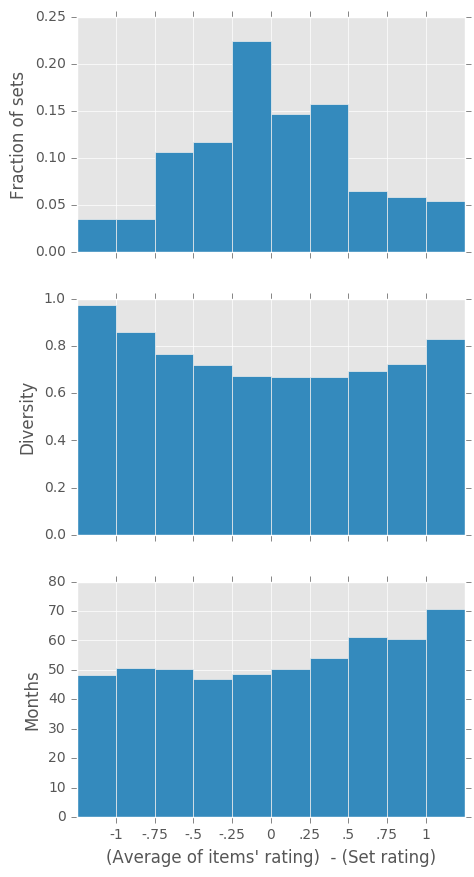

In [298]:
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
f, axarr = plt.subplots(3, sharex=True, figsize=(5,10))
axarr[0].bar(range(len(buckets)), bucketsPcs, width=1)
axarr[0].set_ylabel('Fraction of sets')
axarr[2].set_xlabel('(Average of items\' rating)  - (Set rating)')
axarr[0].set_xticks([1.0, 2, 3, 4, 5, 6, 7, 8, 9])
axarr[0].set_xticklabels(['-1', '-.75', '-.5', '-.25', '0', '.25', '.5', '.75', '1'])

axarr[1].bar(range(len(buckets)), bucketsDev, width=1)
axarr[1].set_ylabel('Diversity')
axarr[2].bar(range(len(buckets)), bucketsTstamp, width=1)
axarr[2].set_ylabel('Months')


In [219]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [27]:
def compBuckProp(listSetSign):
    count = 0.0
    sumDiff = 0.0
    sumDev = 0.0
    sumTstampDiff = 0.0
    for setSign in listSetSign:
        diff = setSign[0]
        setDev = setSign[1]
        tstampDiffSecs = setSign[2]
        sumDiff += diff
        sumDev += setDev
        sumTstampDiff += tstampDiffSecs
        count += 1
    sumDiff = sumDiff/count
    sumDev = sumDev/count
    sumTstampDiff = (sumTstampDiff/count)/(3600*24*30)
    return [sumDiff, sumDev, sumTstampDiff, count]

setsProp = []
underSets   = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}
overSets    = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}
neitherSets = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}

set_buck_neg_1        = []
set_buck_neg_0_99_0_5 = []
set_buck_neg_0_49_0   = []
set_buck_pos_0_0_5    = []
set_buck_pos_0_51_1   = []
set_buck_pos_1        = []

for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items          = setRating[0]
        rating         = setRating[1]
        setDev         = getSetDevFrmAvg(user, items)
        avgRat         = avgSetRat(user, items)
        setRatingType  = isSetUnderOverRat(user, items, rating)
        diff           = avgRat - rating
        oldestTstamp   = getOldestTstampSet(user, items)
        latestTstamp   = datetime.datetime.now()
        tstampDiffSecs = (latestTstamp  - oldestTstamp).total_seconds()
        setSign        = (diff, setDev, tstampDiffSecs)

        if diff > 1:
            set_buck_pos_1.append(setSign)
        elif diff > 0.5 and diff <= 1:
            set_buck_pos_0_51_1.append(setSign)
        elif diff > 0 and diff <= 0.5:
            set_buck_pos_0_0_5.append(setSign)
        elif diff > -0.5 and diff <= 0:
            set_buck_neg_0_49_0.append(setSign)
        elif diff > -1 and diff <= -0.5:
            set_buck_neg_0_99_0_5.append(setSign)
        elif diff <= -1:
            set_buck_neg_1.append(setSign)

        if setRatingType == UNDER_RATED_SET:
            underSets['SE']     += diff*diff
            underSets['SetDev'] += setDev
            underSets['age']    += tstampDiffSecs
            underSets['count']  += 1

        if setRatingType == OVER_RATED_SET:
            overSets['SE']     += diff*diff
            overSets['SetDev'] += setDev
            overSets['age']    += tstampDiffSecs
            overSets['count']  += 1

        if setRatingType == NEITHER_RATED_SET:
            neitherSets['SE']     += diff*diff
            neitherSets['SetDev'] += setDev
            neitherSets['age']    += tstampDiffSecs
            neitherSets['count']  += 1

        setsProp.append((avgRat, setDev, setRatingType, diff, tstampDiffSecs))

buckets = [compBuckProp(set_buck_neg_1),
            compBuckProp(set_buck_neg_0_99_0_5),
            compBuckProp(set_buck_neg_0_49_0),
            compBuckProp(set_buck_pos_0_0_5),
            compBuckProp(set_buck_pos_0_51_1),
            compBuckProp(set_buck_pos_1)]
nSets = 0
for bucket in buckets:
    nSets += bucket[3]
for bucket in buckets:
    bucket[3] = bucket[3]/nSets
sm = 0
for bucket in buckets:
    sm += bucket[3]
    
print 'nSets: ', nSets, ' sm: ', sm

nSets:  29516.0  sm:  1.0


In [28]:
bucketsPcs = [ bucket[3]*100 for bucket in buckets]
bucketsTstamp = [ bucket[2] for bucket in buckets]
bucketsDev = [bucket[1] for bucket in buckets]
buckets[0]

[-1.218385214007784,
 0.97518184028521226,
 48.52241488514245,
 0.03482856755657948]

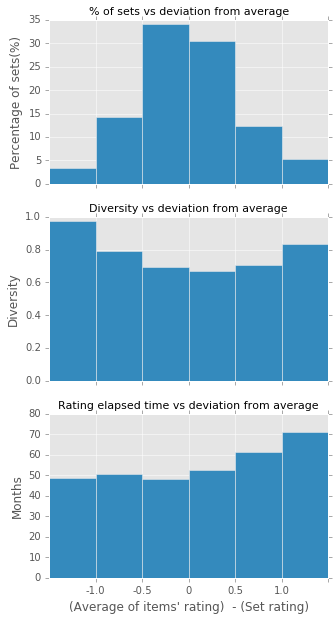

In [29]:
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
f, axarr = plt.subplots(3, sharex=True, figsize=(5,10))
axarr[0].bar(range(len(buckets)), bucketsPcs, width=1)
axarr[0].set_ylabel('Percentage of sets(%)')
axarr[0].set_xticks([1.0, 2, 3, 4, 5, 6, 7, 8, 9])
axarr[0].set_xticklabels(['-1.0', '-0.5', '0', '0.5', '1.0'])
axarr[0].set_title('% of sets vs deviation from average', fontsize=11)

axarr[1].bar(range(len(buckets)), bucketsDev, width=1)
axarr[1].set_ylabel('Diversity')
axarr[1].set_title('Diversity vs deviation from average', fontsize=11)

axarr[2].bar(range(len(buckets)), bucketsTstamp, width=1)
axarr[2].set_ylabel('Months')
axarr[2].set_xlabel('(Average of items\' rating)  - (Set rating)')
axarr[2].set_title('Rating elapsed time vs deviation from average', fontsize=11)

([<matplotlib.axis.XTick at 0x7ff80eec4450>,
 <a list of 3 Text xticklabel objects>)

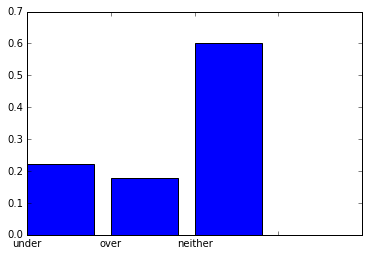

In [58]:
plt.bar(range(3),pcSets)
plt.xticks(range(5), ('under', 'over', 'neither'))

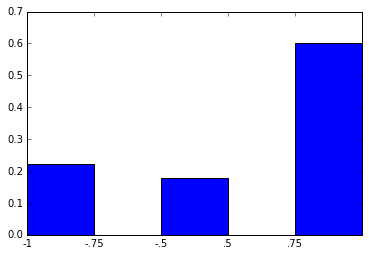

In [73]:
fig, ax = plt.subplots()
ax.bar(range(3),pcSets, width=0.5)
ax.set_xticks([0, 0.5, 1.0, 1.5, 2, 2.5])
ax.set_xticklabels(['-1', '-.75', '-.5', '.5', '.75'])
#ax.set_yticks([0.2, 0.55, 0.76])

In [182]:
len(diverseSetRating), len(nonDiverseSetRating), stats.ttest_ind(diverseSetRating, nonDiverseSetRating)

(6128, 23388, Ttest_indResult(statistic=-39.460155123744791, pvalue=0.0))

In [147]:
def compBuckProp(listSetSign):
    count = 0.0
    sumDiff = 0.0
    sumDev = 0.0
    sumTstampDiff = 0.0
    avgTsDiff = 0.0
    medTsDiff = 0.0
    for setSign in listSetSign:
        diff = setSign[0]
        setDev = setSign[1]
        tstampDiffSecs = setSign[2]
        sumDiff += diff
        sumDev += setDev
        sumTstampDiff += tstampDiffSecs
        avgTsDiff += setSign[3]
        medTsDiff += setSign[4]
        count += 1
    sumDiff = sumDiff/count
    sumDev = sumDev/count
    sumTstampDiff = (sumTstampDiff/count)/(3600*24*30)
    avgTsDiff = (avgTsDiff/count)/(3600*24*30)
    medTsDiff = (medTsDiff/count)/(3600*24*30)
    return [sumDiff, sumDev, sumTstampDiff, avgTsDiff, medTsDiff, count]

setsProp = []
underSets   = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}
overSets    = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}
neitherSets = {'SE': 0.0, 'SetDev': 0.0, 'age': 0.0, 'count': 0.0}

set_buck_neg_1_25      = []
set_buck_neg_1_24_1_0  = []
set_buck_neg_0_99_0_75 = []
set_buck_neg_0_74_0_50  = []
set_buck_neg_0_49_0_25 = []

set_buck_0_24_0_25     = []

set_buck_pos_0_26_0_50  = []
set_buck_pos_0_51_0_75 = []
set_buck_pos_0_76_1_0  = []
set_buck_pos_1_01_1_25 = []
set_buck_pos_1_26      = []

for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items          = setRating[0]
        rating         = setRating[1]
        setDev         = getSetDevFrmAvg(user, items)
        avgRat         = avgSetRat(user, items)
        setRatingType  = isSetUnderOverRat(user, items, rating)
        diff           = avgRat - rating
        oldestTstamp   = getOldestTstampSet(user, items)
        
        medTstamp      = getMedianTstampSet(user, items)
        latestTstamp   = datetime.datetime.now()
        avgTstamp      = getAvgTstampSet(user, items, latestTstamp)
        tstampDiffSecs = (latestTstamp  - oldestTstamp).total_seconds()
        medTsDiffSecs  = (latestTstamp - medTstamp).total_seconds()
        setSign        = (diff, setDev, tstampDiffSecs, avgTstamp, medTsDiffSecs)
        
        if diff > 1.25:
            set_buck_pos_1_26.append(setSign)
        elif diff > 1 and diff <= 1.25:
            set_buck_pos_1_01_1_25.append(setSign)
        elif diff > 0.75 and diff <= 1.0:
            set_buck_pos_0_76_1_0.append(setSign)
        elif diff > 0.5 and diff <= 0.75:
            set_buck_pos_0_51_0_75.append(setSign)
        elif diff > 0.25 and diff <= 0.5:
            set_buck_pos_0_26_0_50.append(setSign)
        elif diff > -0.25 and diff <= 0.25:
            set_buck_0_24_0_25.append(setSign)
        
        elif diff > -0.5 and diff <= -0.25:
            set_buck_neg_0_49_0_25.append(setSign)
            
        elif diff > -0.75 and diff <= -0.5:
            set_buck_neg_0_74_0_50.append(setSign)
        elif diff > -1 and diff <= -0.75:
            set_buck_neg_0_99_0_75.append(setSign)
        elif diff > -1.25 and diff <= -1:
            set_buck_neg_1_24_1_0.append(setSign)
        elif diff <= -1.25:
            set_buck_neg_1_25.append(setSign)

        if setRatingType == UNDER_RATED_SET:
            underSets['SE']     += diff*diff
            underSets['SetDev'] += setDev
            underSets['age']    += tstampDiffSecs
            underSets['count']  += 1

        if setRatingType == OVER_RATED_SET:
            overSets['SE']     += diff*diff
            overSets['SetDev'] += setDev
            overSets['age']    += tstampDiffSecs
            overSets['count']  += 1

        if setRatingType == NEITHER_RATED_SET:
            neitherSets['SE']     += diff*diff
            neitherSets['SetDev'] += setDev
            neitherSets['age']    += tstampDiffSecs
            neitherSets['count']  += 1

        setsProp.append((avgRat, setDev, setRatingType, diff, tstampDiffSecs))

buckets = [compBuckProp(set_buck_neg_1_25),
           compBuckProp(set_buck_neg_1_24_1_0),
           compBuckProp(set_buck_neg_0_99_0_75),
           compBuckProp(set_buck_neg_0_74_0_50),
           compBuckProp(set_buck_neg_0_49_0_25),
           compBuckProp(set_buck_0_24_0_25),
           compBuckProp(set_buck_pos_0_26_0_50),
           compBuckProp(set_buck_pos_0_51_0_75),
           compBuckProp(set_buck_pos_0_76_1_0),
           compBuckProp(set_buck_pos_1_01_1_25),
           compBuckProp(set_buck_pos_1_26)
          ]

nSets = 0
for bucket in buckets:
    nSets += bucket[5]
    
for bucket in buckets:
    bucket[5] = bucket[5]/nSets
    
sm = 0
for bucket in buckets:
    sm += bucket[5]
    
print 'nSets: ', nSets, ' sm: ', sm

nSets:  29516.0  sm:  1.0


In [148]:
bucketsPcs = [ bucket[5]*100 for bucket in buckets]
bucketsTstamp = [ bucket[2] for bucket in buckets]
bucketsAvgTstamp = [bucket[3] for bucket in buckets]
bucketsMedTstamp = [bucket[4] for bucket in buckets]
bucketsDev = [bucket[1] for bucket in buckets]
buckets[0]

[-1.5071428571428573,
 1.0342833532489724,
 45.585311759728846,
 35.321953989942678,
 36.31716704476337,
 0.01138365632199485]

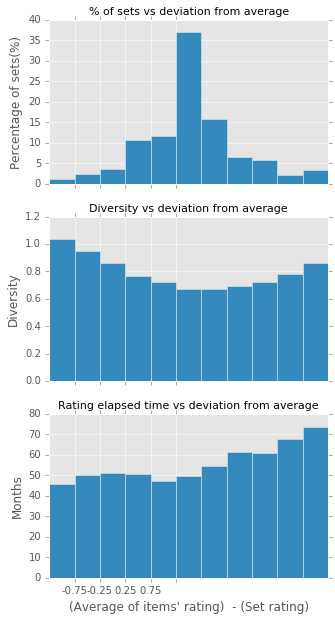

In [37]:
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
f, axarr = plt.subplots(3, sharex=True, figsize=(5,10))
axarr[0].bar(range(len(buckets)), bucketsPcs, width=1)
axarr[0].set_ylabel('Percentage of sets(%)')
axarr[0].set_xticks([1.0, 2, 3, 4, 5,])
axarr[0].set_xticklabels(['-0.75', '-0.25', '0.25', '0.75'])
axarr[0].set_title('% of sets vs deviation from average', fontsize=11)

axarr[1].bar(range(len(buckets)), bucketsDev, width=1)
axarr[1].set_ylabel('Diversity')
axarr[1].set_title('Diversity vs deviation from average', fontsize=11)

axarr[2].bar(range(len(buckets)), bucketsTstamp, width=1)
axarr[2].set_ylabel('Months')
axarr[2].set_xlabel('(Average of items\' rating)  - (Set rating)')
axarr[2].set_title('Rating elapsed time vs deviation from average', fontsize=11)

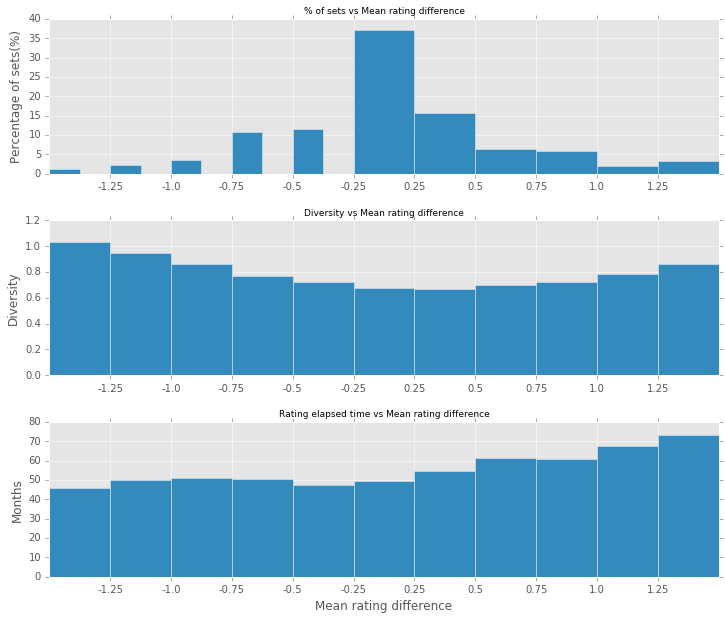

In [45]:
plt.style.use('ggplot')

f = plt.figure( figsize=(12,10))
plt.subplots_adjust(hspace=0.3)
ax1 = plt.subplot(311)
ax1.bar(range(len(buckets)), bucketsPcs, 
        width=[0.5, 0.5, 0.5, 0.5, 0.5, 1,1,1,1,1, 1])
ax1.set_ylabel('Percentage of sets(%)')
ax1.set_xticks([1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax1.set_xticklabels(['-1.25', '-1.0', '-0.75', '-0.5', '-0.25', '0.25', '0.5', '0.75', '1.0', '1.25'])
ax1.set_title('% of sets vs Mean rating difference', fontsize=9)

"""
ax1.text(4.5, 28, 'Under-rated')
ax1.annotate('', xy=(6, 25), xytext=(4.5, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax1.text(1, 28, 'Over-rated')
ax1.annotate('', xy=(0.5, 25), xytext=(2.5, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
"""

ax2 = plt.subplot(312, sharex=ax1)
ax2.bar(range(len(buckets)), bucketsDev, width=1)
ax2.set_ylabel('Diversity')
ax2.set_title('Diversity vs Mean rating difference', fontsize=9)

ax3 = plt.subplot(313, sharex=ax1)
ax3.bar(range(len(buckets)), bucketsTstamp, width=1)
ax3.set_ylabel('Months')
ax3.set_xlabel('Mean rating difference')
ax3.set_title('Rating elapsed time vs Mean rating difference', fontsize=9)

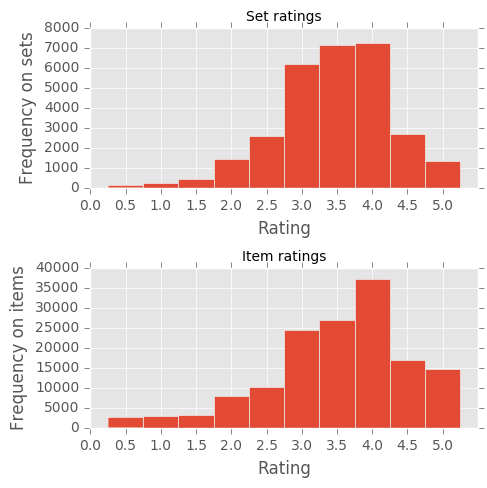

In [349]:
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

f = plt.figure(figsize=(5,5))
plt.subplots_adjust(hspace=0.5)

data = ratings
data = np.array(data)
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2

ax1 = plt.subplot(211)
ax1.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.set_ylabel('Frequency on sets')
ax1.set_xlabel('Rating')
ax1.set_xticks(np.arange(0, 5.5, 0.5))
ax1.set_xlim((0, 5.5))
ax1.set_title('Set ratings', fontsize=10)

data = np.array(itemRatings)
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
ax2 = plt.subplot(212, sharex=ax1)

ax2.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax2.set_xticks(np.arange(0, 5.5, 0.5))
ax2.set_ylabel('Frequency on items')
ax2.set_xlabel('Rating')
ax2.set_xlim((0, 5.5))
f = plt.figure(figsize = (20,6))

[x,y,z] = randLabels()ax2.set_title('Item ratings', fontsize=10)

0.21975 0.1699375 0.6103125


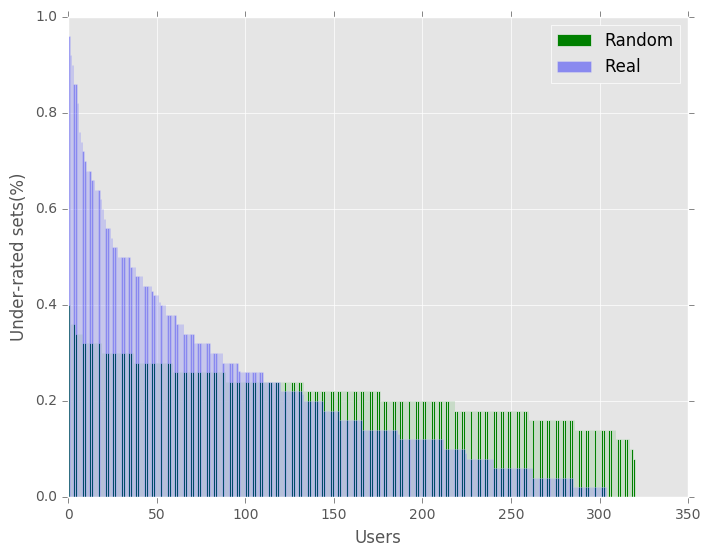

In [512]:
#plt.style.use('ggplot')
#f = plt.figure()

[x,y,z] = randLabels()


pcTuples.sort(key = lambda tup: tup[1])
pcTuples.sort(key = lambda tup: tup[2])
pcTuples.sort(key = lambda tup: tup[0], reverse=True)

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])

#f.patch.set_facecolor('blue')
#f.patch.set_alpha(0)
ax1.bar(x, underRatedPcs, label='Real', color = 'b', alpha=0.4)#, hatch='O', width=1, linewidth=0)
#plt.bar(x, overRatedPcs, color = 'black', bottom = underRatedPcs, label='Over-rated', hatch='*', width=1, linewidth=0)
#plt.bar(x, neitherRatedPcs, color='w', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='Neither',
#       hatch='/', width=1, linewidth=0)
#plt.axis("tight")
#plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=15)
ax1.legend()
ax1.xlabel('Users')#, fontsize='18')
ax1.ylabel('Under-rated sets(%)')#, fontsize='18')
#plt.tick_params(axis='both', which='major', labelsize=15)
#plt.tick_params(axis='both', which='minor', labelsize=15)


In [515]:
def randLabels():
    permSetsLabel = np.random.permutation(setsLabel)
    uPermSetsPc = {}
    uPermPcTuples = []
    for u in range(320):
        start = u*50
        uSetsLabel = permSetsLabel[start:start+50]
        underCount = 0.0
        overCount = 0.0
        for label in uSetsLabel:
            if label == UNDER_RATED_SET:
                underCount += 1
            elif label == OVER_RATED_SET:
                overCount += 1
        neitherCount = 50.0 - (underCount + overCount)
        underPc   = underCount/50
        overPc    = overCount/50
        neitherPC = neitherCount/50
        uPermSetsPc[u] = [underPc, overPc, neitherPC]
        uPermPcTuples.append((underPc, overPc, neitherPC))
    uPermPcTuples.sort(key = lambda tup: tup[1], reverse=True)
    #uPermPcTuples.sort(key = lambda tup: tup[2])
    #uPermPcTuples.sort(key = lambda tup: tup[0], reverse=True)
    nUsers = len(uPermPcTuples)
    x = range(nUsers)
    underRatedPcs = []
    overRatedPcs = []
    neitherRatedPcs = []

    for pcTuple in uPermPcTuples:
        underRatedPcs.append(pcTuple[0])
        overRatedPcs.append(pcTuple[1])
        neitherRatedPcs.append(pcTuple[2])
    #plt.style.use('classic')
    #f = plt.figure(figsize = (20,6))
    #plt.bar(x, overRatedPcs, color = 'r', label='overRated')
    #plt.bar(x, underRatedPcs, color = 'b', bottom=overRatedPcs, label='underRated')
    #plt.bar(x, underRatedPcs, color = 'g', label='Random')
    plt.bar(x, overRatedPcs, color = 'g', label='Random')
    #plt.bar(x, neitherRatedPcs, color='g', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='neitherRated')
    #plt.axis("tight")
    #plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
    #plt.ylim((0,1))
    #plt.xlabel('Users')
    #plt.ylabel('Under-rated sets (%)')
    
    print np.average(underRatedPcs), np.average(overRatedPcs), np.average(neitherRatedPcs)
    return (underRatedPcs, overRatedPcs, neitherRatedPcs)

#[randUnderRatedPcs, randOverRatedPcs, randNeitherRatedPcs] = randLabels()

0.2201875 0.1705 0.6093125


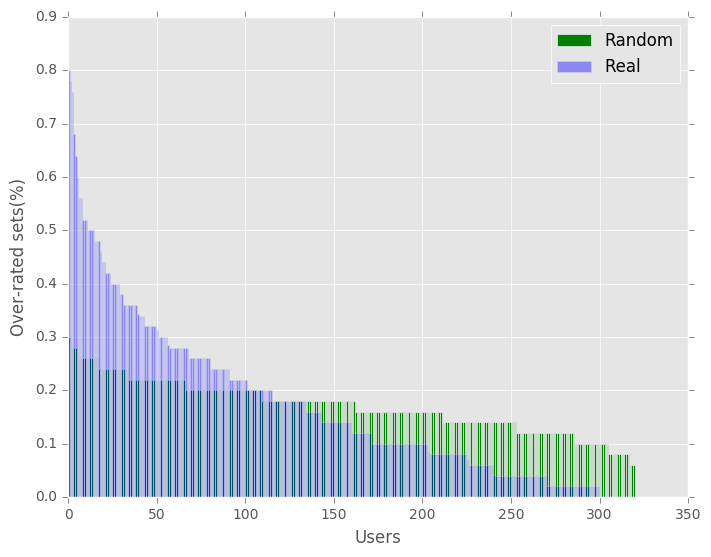

In [535]:
plt.style.use('ggplot')
f = plt.figure()

[x,y,z] = randLabels()


pcTuples.sort(key = lambda tup: tup[1], reverse=True)
#pcTuples.sort(key = lambda tup: tup[2])
#pcTuples.sort(key = lambda tup: tup[0], reverse=True)

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])
    
plt.bar(x, overRatedPcs, label='Real', color = 'b', alpha=0.4)
plt.legend()
plt.xlabel('Users')
plt.ylabel('Over-rated sets(%)')

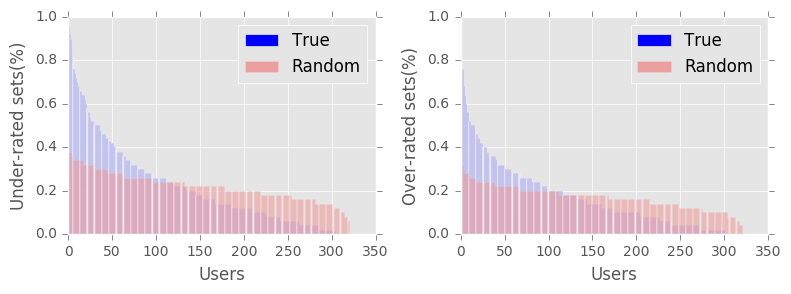

In [607]:
plt.style.use('ggplot')
f = plt.figure(figsize=(8,3))
plt.subplots_adjust(hspace=1.5)

ax1 = plt.subplot(121)

pcTuples.sort(key = lambda tup: tup[0], reverse=True)

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])

ax1.bar(x, underRatedPcs, label='True', color = 'b')#, hatch='O', width=1, linewidth=0)
permSetsLabel = np.random.permutation(setsLabel)
uPermSetsPc = {}
uPermPcTuples = []
for u in range(320):
    start = u*50
    uSetsLabel = permSetsLabel[start:start+50]
    underCount = 0.0
    overCount = 0.0
    for label in uSetsLabel:
        if label == UNDER_RATED_SET:
            underCount += 1
        elif label == OVER_RATED_SET:
            overCount += 1
    neitherCount = 50.0 - (underCount + overCount)
    underPc   = underCount/50
    overPc    = overCount/50
    neitherPC = neitherCount/50
    uPermSetsPc[u] = [underPc, overPc, neitherPC]
    uPermPcTuples.append((underPc, overPc, neitherPC))

uPermPcTuples.sort(key = lambda tup: tup[0], reverse=True)
nUsers = len(uPermPcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in uPermPcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])

ax1.bar(x, underRatedPcs, color = 'r', alpha=0.3, label='Random')
ax1.legend()
ax1.set_xlabel('Users')
ax1.set_ylabel('Under-rated sets(%)')

ax2 = plt.subplot(122)
pcTuples.sort(key = lambda tup: tup[1], reverse=True)

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])

ax2.bar(x, overRatedPcs, label='True', color = 'b')
permSetsLabel = np.random.permutation(setsLabel)
uPermSetsPc = {}
uPermPcTuples = []
for u in range(320):
    start = u*50
    uSetsLabel = permSetsLabel[start:start+50]
    underCount = 0.0
    overCount = 0.0
    for label in uSetsLabel:
        if label == UNDER_RATED_SET:
            underCount += 1
        elif label == OVER_RATED_SET:
            overCount += 1
    neitherCount = 50.0 - (underCount + overCount)
    underPc   = underCount/50
    overPc    = overCount/50
    neitherPC = neitherCount/50
    uPermSetsPc[u] = [underPc, overPc, neitherPC]
    uPermPcTuples.append((underPc, overPc, neitherPC))

uPermPcTuples.sort(key = lambda tup: tup[1], reverse=True)
nUsers = len(uPermPcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in uPermPcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])

ax2.bar(x, overRatedPcs, color = 'r', alpha=0.3, label='Random')
ax2.legend()
ax2.set_xlabel('Users')
ax2.set_ylabel('Over-rated sets(%)')
ax2.set_ylim((0,1))
plt.tight_layout()

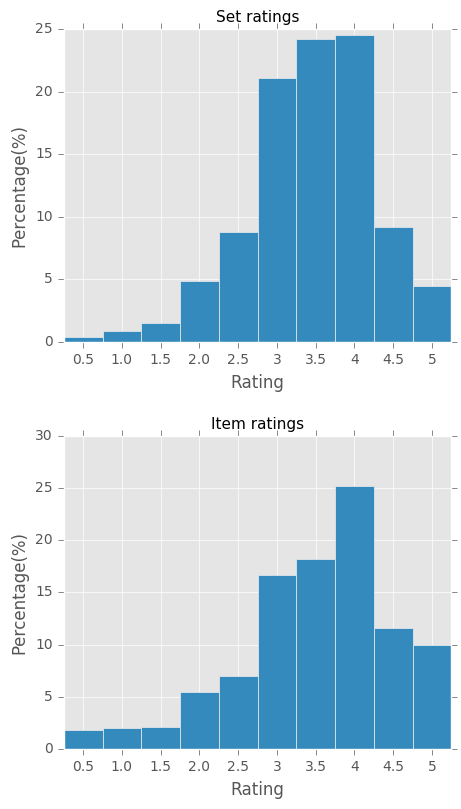

In [602]:


np.average(ratings), np.average(itemRatings)

np.var(ratings), np.var(itemRatings)

setRatCounts = {}
itemRatCount = {}
for rating in ratings:
    if rating not in setRatCounts:
        setRatCounts[rating] = 0
    setRatCounts[rating] += 1
for rating in itemRatings:
    if rating not in itemRatCount:
        itemRatCount[rating] = 0
    itemRatCount[rating] += 1

for k, v in setRatCounts.iteritems():
    setRatCounts[k] = float(setRatCounts[k])/len(ratings)
for k, v in itemRatCount.iteritems():
    itemRatCount[k] = float(itemRatCount[k])/len(itemRatings)

plt.style.use('ggplot')

ks = setRatCounts.keys()
ks.sort()

setRatPc = [setRatCounts[k]*100 for k in ks]
itemRatPc = [itemRatCount[k]*100 for k in ks]

f = plt.figure( figsize=(5,9))
plt.subplots_adjust(hspace=0.3)
ax1 = plt.subplot(211)
ax1.bar(range(len(setRatPc)), setRatPc, width=1)
ax1.set_ylabel('Percentage(%)')
ax1.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
ax1.set_xticklabels(['0.5', '1.0', '1.5', '2.0', '2.5', '3', '3.5', '4', '4.5', '5'])
ax1.set_title('Set ratings', fontsize=11)
ax1.set_xlabel('Rating')

ax2 = plt.subplot(212, sharex=ax1)
ax2.bar(range(len(itemRatPc)), itemRatPc, width=1)
ax2.set_ylabel('Percentage(%)')
ax2.set_title('Item ratings', fontsize=11)
ax2.set_xlabel('Rating')

([<matplotlib.axis.XTick at 0x7f031ab74810>,
 <a list of 8 Text xticklabel objects>)

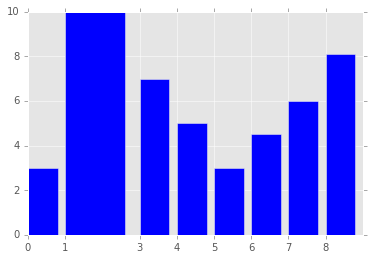

In [49]:

y = [3, 10, 7, 5, 3, 4.5, 6, 8.1]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar([0, 1, 3, 4, 5, 6, 7, 8], y, [0.8, 1.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], color="blue")
plt.xticks([0, 1, 3, 4, 5, 6, 7, 8])

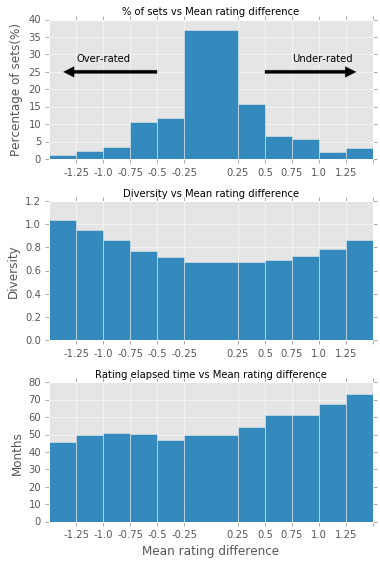

In [101]:
plt.style.use('ggplot')

f = plt.figure( figsize=(5.8,9))
plt.subplots_adjust(hspace=0.3)
x = [0, 0.5, 1, 1.5, 2, 2.5, 3.5, 4, 4.5, 5, 5.5]
xwidth = [0.5, 0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 0.5]
ax1 = plt.subplot(311)
ax1.bar(x, bucketsPcs, width=xwidth)
ax1.set_ylabel('Percentage of sets(%)')
ax1.set_xticks([0.5, 1, 1.5, 2, 2.5, 3.5, 4, 4.5, 5, 5.5, 6])
ax1.set_xticklabels(['-1.25', '-1.0', '-0.75', '-0.5', '-0.25', '0.25', '0.5', '0.75', '1.0', '1.25'])
ax1.set_title('% of sets vs Mean rating difference', fontsize=10)

ax1.text(4.5, 28, 'Under-rated')
ax1.annotate('', xy=(5.8, 25), xytext=(3.9, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax1.text(0.5, 28, 'Over-rated')
ax1.annotate('', xy=(0.15, 25), xytext=(2.1, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax2 = plt.subplot(312, sharex=ax1)
ax2.bar(x, bucketsDev, xwidth)
ax2.set_ylabel('Diversity')
ax2.set_title('Diversity vs Mean rating difference', fontsize=10)

ax3 = plt.subplot(313, sharex=ax1)
ax3.bar(x, bucketsTstamp, xwidth)
ax3.set_ylabel('Months')
ax3.set_xlabel('Mean rating difference')
ax3.set_title('Rating elapsed time vs Mean rating difference', fontsize=10)

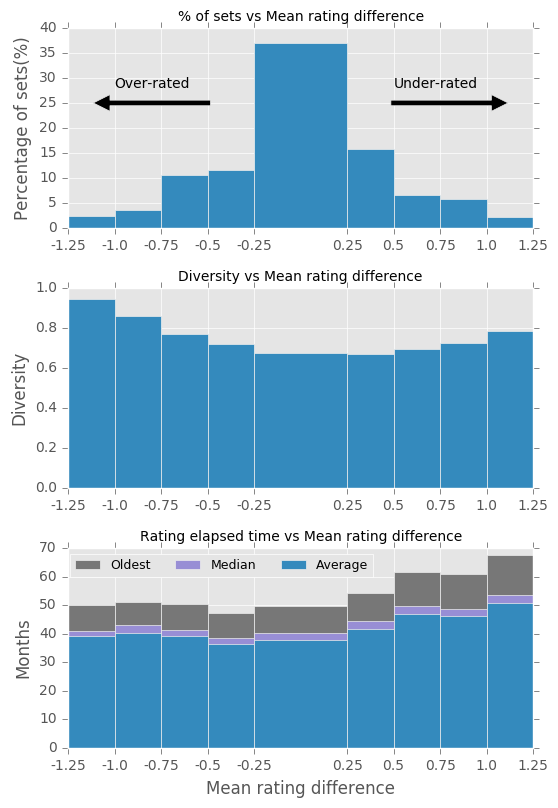

In [208]:
plt.style.use('ggplot')

colors = plt.rcParams['axes.color_cycle']

f = plt.figure( figsize=(6,9))
plt.subplots_adjust(hspace=0.3)
x = [0, 0.5, 1, 1.5, 2, 3, 3.5, 4, 4.5]
xwidth = [ 0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5]
ax1 = plt.subplot(311)
ax1.bar(x, bucketsPcs[1:-1], width=xwidth)
ax1.set_ylabel('Percentage of sets(%)')
ax1.set_xticks([0, 0.5, 1, 1.5, 2, 3, 3.5, 4, 4.5, 5])
ax1.set_xticklabels(['-1.25', '-1.0', '-0.75', '-0.5', '-0.25', '0.25', '0.5', '0.75', '1.0', '1.25'])
ax1.set_title('% of sets vs Mean rating difference', fontsize=10)

ax1.text(3.5, 28, 'Under-rated')
ax1.annotate('', xy=(4.8, 25), xytext=(3.4, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax1.text(0.5, 28, 'Over-rated')
ax1.annotate('', xy=(0.2, 25), xytext=(1.6, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax2 = plt.subplot(312, sharex=ax1)
ax2.bar(x, bucketsDev[1:-1], xwidth)
ax2.set_ylabel('Diversity')
ax2.set_title('Diversity vs Mean rating difference', fontsize=10)

ax3 = plt.subplot(313, sharex=ax1)
ax3.bar(x, bucketsTstamp[1:-1], xwidth, color = colors[3],   label='Oldest')
ax3.bar(x, bucketsMedTstamp[1:-1], xwidth, color = colors[2], label = 'Median' )
ax3.bar(x, bucketsAvgTstamp[1:-1], xwidth, color = colors[1], label = 'Average')
ax3.legend(loc=9, bbox_to_anchor=(0.33, 1.0), ncol=3, fontsize=9)

ax3.set_ylabel('Months')
ax3.set_xlabel('Mean rating difference')
ax3.set_title('Rating elapsed time vs Mean rating difference', fontsize=10)

In [150]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(left, height, width=0.8, bottom=None, hold=None, data=None, **kwargs)
    Make a bar plot.
    
    Make a bar plot with rectangles bounded by:
    
      `left`, `left` + `width`, `bottom`, `bottom` + `height`
            (left, right, bottom and top edges)
    
    Parameters
    ----------
    left : sequence of scalars
        the x coordinates of the left sides of the bars
    
    height : sequence of scalars
        the heights of the bars
    
    width : scalar or array-like, optional
        the width(s) of the bars
        default: 0.8
    
    bottom : scalar or array-like, optional
        the y coordinate(s) of the bars
        default: None
    
    color : scalar or array-like, optional
        the colors of the bar faces
    
    edgecolor : scalar or array-like, optional
        the colors of the bar edges
    
    linewidth : scalar or array-like, optional
        width of bar edge(s). If None, use default
      